# <center>ILLUMI MARKET</center>#
#  NAMES: Panongbene Jean Mohamed Sawadogo #
# Email: amet1900@gmail.com #
# Github: https://github.com/Panongbene/PROJECT_DATA_SCIENCE #

## Import Libraries

In [1]:
import json
import logging
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
from tensorflow import keras
from keras.layers import LSTM
from datetime import datetime
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import layers
from keras.models import Sequential
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

## Variables

In [2]:
plt.style.use('fivethirtyeight')
sns.set()
path_csv_data = "data/test.csv"

# Useful function

In [3]:
def get_second_from_datetime(x):
    """
        uses this function to get timestamp of date time
    """
    return x.timestamp()

# VISUALIZATION and ANALYSIS DATASET

## Data content import and analysis

In [4]:
data_set = pd.read_csv(path_csv_data, sep=',')

In [5]:
data_set.head(10)

,date,Price,exogenous_1,exogenous_2
0,1/9/2012 0:00,34.97,16382.00,3569.52750
1,1/9/2012 1:00,33.43,15410.50,3315.27500
2,1/9/2012 2:00,32.74,15595.00,3107.30750
3,1/9/2012 3:00,32.46,16521.00,2944.62000
4,1/9/2012 4:00,32.50,17700.75,2897.15000
5,1/9/2012 5:00,36.13,19348.75,2676.35000
6,1/9/2012 6:00,43.02,23058.50,2533.84750
7,1/9/2012 7:00,59.03,25349.25,2555.86750
8,1/9/2012 8:00,64.48,26336.75,2818.96925
9,1/9/2012 9:00,58.72,26321.00,3386.18700


###### Shape DataSet

In [6]:
print(data_set.shape)

(52416, 4)


###### Data type in each column

In [7]:
print(data_set.dtypes)

date            object
Price          float64
exogenous_1    float64
exogenous_2    float64
dtype: object


In [8]:
data_set['date']= pd.to_datetime(data_set['date'])

In [9]:
print(data_set.dtypes)

date           datetime64[ns]
Price                 float64
exogenous_1           float64
exogenous_2           float64
dtype: object


In [10]:
data_set

,date,Price,exogenous_1,exogenous_2
0,2012-01-09 00:00:00,34.97,16382.00,3569.52750
1,2012-01-09 01:00:00,33.43,15410.50,3315.27500
2,2012-01-09 02:00:00,32.74,15595.00,3107.30750
3,2012-01-09 03:00:00,32.46,16521.00,2944.62000
4,2012-01-09 04:00:00,32.50,17700.75,2897.15000
...,...,...,...,...
52411,2017-12-31 19:00:00,7.92,16601.00,30649.08950
52412,2017-12-31 20:00:00,4.06,15977.75,30034.54300
52413,2017-12-31 21:00:00,5.30,15715.00,29653.00775
52414,2017-12-31 22:00:00,1.86,15876.00,29520.32950


###### Missing Data 

In [11]:
column_data_set=data_set.columns
column_to_delete=[]
column_uses_for_the_training=[]

for i in range(4):
    percentage=100*(data_set[data_set[column_data_set[i]].isnull()].shape[0]/data_set.shape[0])
    if(percentage >= 15):
        column_to_delete.append(column_data_set[i])
    else:
        column_uses_for_the_training.append(column_data_set[i])
    print(column_data_set[i]," = ", data_set[data_set[column_data_set[i]].isnull()].shape[0]," = ",percentage,"%train")

date  =  0  =  0.0 %train
Price  =  0  =  0.0 %train
exogenous_1  =  0  =  0.0 %train
exogenous_2  =  0  =  0.0 %train


## Visualization

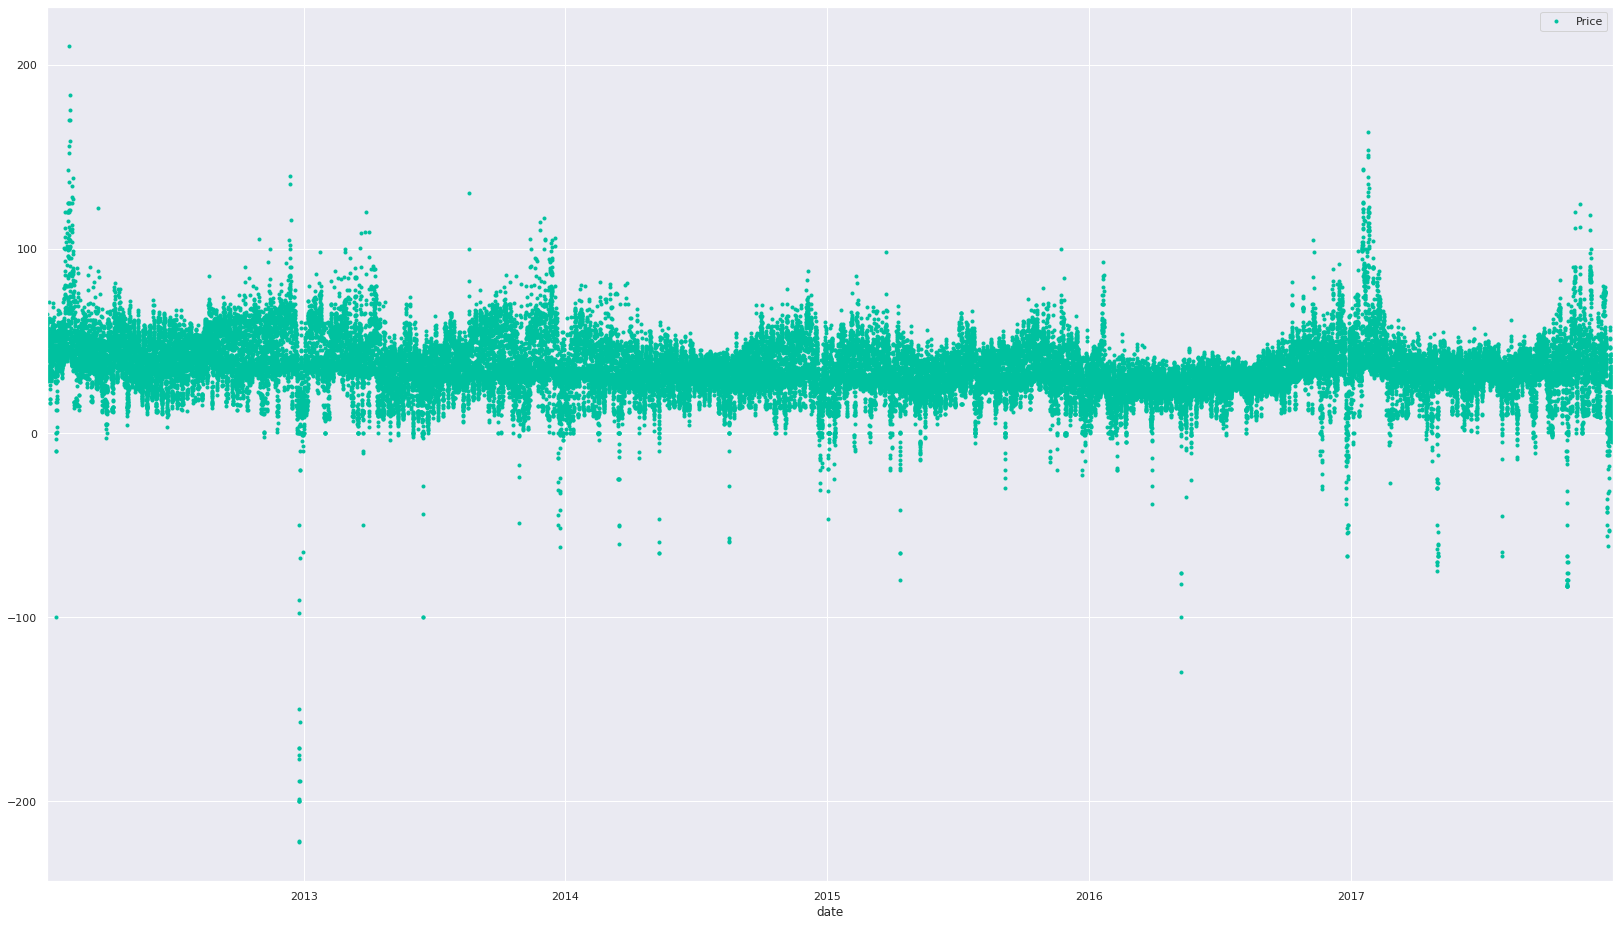

In [12]:
data_set[["date", "Price"]].plot(x='date', y='Price', style='.', color="#00C19F" ,figsize=(25,15))
plt.show()

#### Decomposing the time series

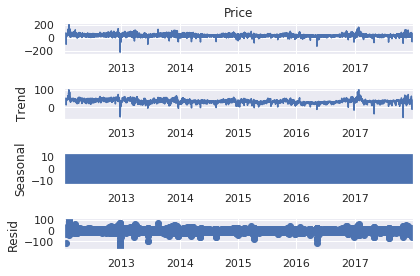

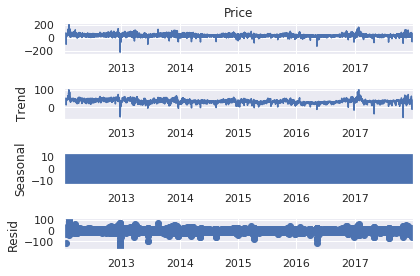

In [13]:
electricity_market_data_1 = data_set.copy()
electricity_market_data_1.index = pd.to_datetime(electricity_market_data_1.date)
decomposable_components = seasonal_decompose(x=electricity_market_data_1['Price'])
decomposable_components.plot()

#### Correlation matrix

[]

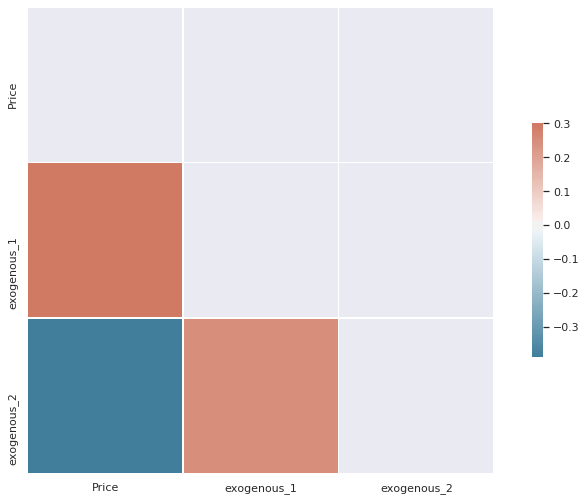

In [14]:
X_train_X = data_set.loc[:, ~data_set.columns.isin(['date'])]
corr = X_train_X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.plot()

#### Correlation matrix Feature/Target after Preprocessing Preprocessing

In [15]:
df_corelation = data_set.copy()
df_corelation['date'] = df_corelation.date
df_corelation['hour'] = df_corelation['date'].dt.hour
df_corelation['second'] = df_corelation["date"].apply(get_second_from_datetime)
df_corelation['secondDivided1'] = df_corelation["date"].apply(get_second_from_datetime)/df_corelation['exogenous_1']
df_corelation['secondDivided2'] = df_corelation["date"].apply(get_second_from_datetime)/df_corelation['exogenous_2']
df_corelation['secondHours'] = df_corelation["date"].apply(get_second_from_datetime)/3600
df_corelation['secondMinutes'] = df_corelation["date"].apply(get_second_from_datetime)/60
df_corelation['secondDay'] = df_corelation["date"].apply(get_second_from_datetime)/86400
df_corelation['secondMonth'] = df_corelation["date"].apply(get_second_from_datetime)/2592000
df_corelation['secondYear'] = df_corelation["date"].apply(get_second_from_datetime)/31622400
df_corelation['dayofweek'] = df_corelation['date'].dt.dayofweek
df_corelation['quarter'] = df_corelation['date'].dt.quarter
df_corelation['month'] = df_corelation['date'].dt.month
df_corelation['year'] = df_corelation['date'].dt.year
df_corelation['year_tec'] = df_corelation['date'].dt.day/df_corelation['date'].dt.year
df_corelation['dayofyear'] = df_corelation['date'].dt.dayofyear
df_corelation['dayofmonth'] = df_corelation['date'].dt.day
df_corelation['weekofyear'] = df_corelation['date'].dt.weekofyear
df_corelation['exogenous_1'] = df_corelation['exogenous_1']
df_corelation['exogenous_2'] = df_corelation['exogenous_2']
df_corelation['exogenous'] = df_corelation['exogenous_1']-df_corelation['exogenous_2']
df_corelation['exogenous_3'] = df_corelation['exogenous_1']/df_corelation['exogenous_2']
df_corelation['exogenous_4'] = df_corelation['exogenous_2']/df_corelation['exogenous_1']

[]

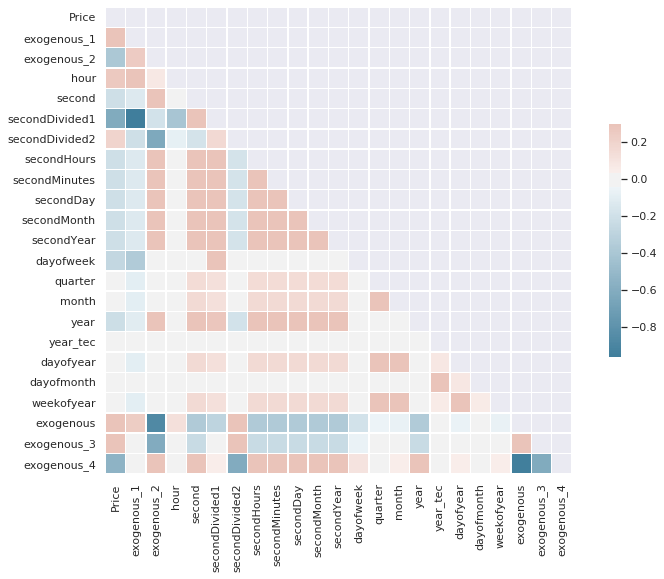

In [16]:
X_train_X = df_corelation.loc[:, ~df_corelation.columns.isin(['date'])]
corr = X_train_X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.plot()

### Testing

In [17]:
result_1 = data_set[data_set.Price < 150]
result_1 = result_1[result_1.Price > -150]

In [18]:
data_set[data_set.Price < -150]

,date,Price,exogenous_1,exogenous_2
8425,2012-12-25 01:00:00,-200.00,15247.75,18526.26000
8426,2012-12-25 02:00:00,-221.99,15258.25,17642.72500
8427,2012-12-25 03:00:00,-221.94,15378.50,16580.31750
8428,2012-12-25 04:00:00,-199.89,15419.25,14581.35500
8429,2012-12-25 05:00:00,-199.00,15199.00,13166.03750
8430,2012-12-25 06:00:00,-199.94,14731.00,12105.62250
8449,2012-12-26 01:00:00,-174.99,14764.00,19473.04750
8450,2012-12-26 02:00:00,-176.92,14794.25,19136.66750
8451,2012-12-26 03:00:00,-188.91,15324.75,18530.53250
8452,2012-12-26 04:00:00,-170.92,15581.50,17629.66500


In [19]:
data_set[data_set.Price > 150]

,date,Price,exogenous_1,exogenous_2
728,2012-02-08 08:00:00,156.00,28714.25,5169.26275
737,2012-02-08 17:00:00,151.88,28507.25,2771.60825
738,2012-02-08 18:00:00,210.00,29931.00,2429.09500
739,2012-02-08 19:00:00,169.90,29579.50,2320.16750
762,2012-02-09 18:00:00,169.90,30367.50,7597.14000
775,2012-02-10 07:00:00,183.49,28621.75,2088.58000
776,2012-02-10 08:00:00,175.55,29544.00,2515.97875
786,2012-02-10 18:00:00,158.33,29533.25,2225.27500
44215,2017-01-24 07:00:00,163.52,25712.50,1247.39425
44216,2017-01-24 08:00:00,153.67,26826.50,1502.75100


# Modelling

In [20]:
electricity_market_data = data_set#result_1#[["date", "Price"]]
split_date = '01-Jan-2016'
electricity_market_data_train = result_1.loc[result_1.date <= split_date].copy()
electricity_market_data_test = electricity_market_data.loc[electricity_market_data.date > split_date].copy()

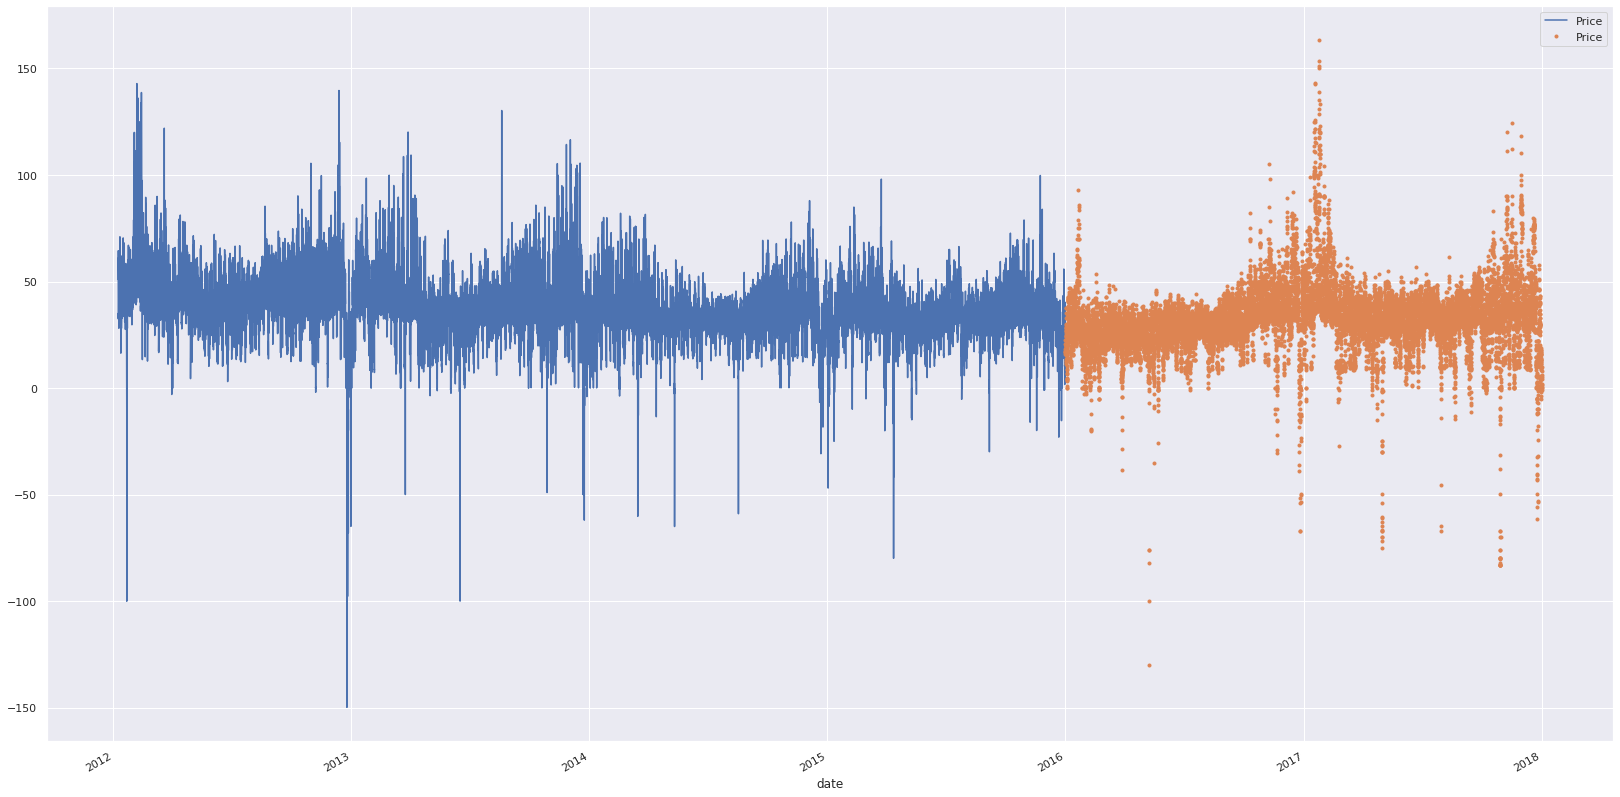

In [21]:
ax = electricity_market_data_train.plot(x='date', y='Price')
electricity_market_data_test.plot(ax=ax, x='date', y='Price', style='.', figsize=(25,15))
plt.show()

In [22]:
def get_second_from_datetime(x):
    return x.timestamp()

## ----------------------------------------------------------------------------------------- ##
## ----------------------------------------------------------------------------------------- ##
## ----------------------------------------------------------------------------------------- ##

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.date
    #df['hour'] = df['date'].dt.hour
    #df['second'] = df["date"].apply(get_second_from_datetime)
    df['secondDivided1'] = df["date"].apply(get_second_from_datetime)/df['exogenous_1']#6.046363158378864
    df['secondDivided2'] = df["date"].apply(get_second_from_datetime)/df['exogenous_2']
    
    #df['secondHours'] = df["date"].apply(get_second_from_datetime)/3600
    #df['secondMinutes'] = df["date"].apply(get_second_from_datetime)/60
    #df['secondDay'] = df["date"].apply(get_second_from_datetime)/86400
    #df['secondMonth'] = df["date"].apply(get_second_from_datetime)/2592000
    #df['secondYear'] = df["date"].apply(get_second_from_datetime)/31622400
    
    #df['dayofweek'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    #df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    #df['year_tec'] = df['date'].dt.day/df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['exogenous_1'] = df['exogenous_1']
    df['exogenous_2'] = df['exogenous_2']
    #df['exogenous'] = df['exogenous_1']-df['exogenous_2']
    #df['exogenous_3'] = df['exogenous_1']/df['exogenous_2']
    #df['exogenous_4'] = df['exogenous_2']/df['exogenous_1']
   
    #X = df[['hour','dayofweek','quarter','month','year',
    #       'dayofyear','dayofmonth','weekofyear']]
    X = df.loc[:, ~df.columns.isin(['date', label])]
    
    if label:
        y = df[label]
        return X, y
    return X

In [23]:
X_train, y_train = create_features(electricity_market_data_train, label='Price')
X_test, y_test = create_features(electricity_market_data_test, label='Price')

In [24]:
X_test

,exogenous_1,exogenous_2,secondDivided1,secondDivided2
34873,16190.75,7422.22625,89656.748452,195576.091473
34874,15906.25,7265.30200,91260.579961,199800.861685
34875,15884.00,7179.43375,91388.642659,202191.043270
34876,16091.75,7015.89450,90209.007721,206904.593563
34877,16802.25,6788.22650,86394.643575,213844.426081
...,...,...,...,...
52411,16601.00,30649.08950,91244.310584,49422.244664
52412,15977.75,30034.54300,94803.736446,50433.609061
52413,15715.00,29653.00775,96389.055043,51082.642704
52414,15876.00,29520.32950,95411.791383,51312.354085


### XGBoosting

In [25]:
start_time = datetime.now()
reg_xgbooting = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
reg_xgbooting.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=10,
       verbose=False) # Change verbose to True if you want to see it train
print(reg_xgbooting)
y_pred = reg_xgbooting.predict(X_test)
thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
tmin, tsec = divmod(temp_sec, 60)
print('\nTime taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Time taken: 0 hours 0 minutes and 5.26 seconds.


In [26]:
# Overfitting Model
#reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)

#reg.fit(X_train, y_train,
#        eval_set=[(X_train, y_train), (X_test, y_test)],
#        early_stopping_rounds=1000,
#       verbose=False)
#y_pred = reg.predict(X_test)

#####  Loss Function

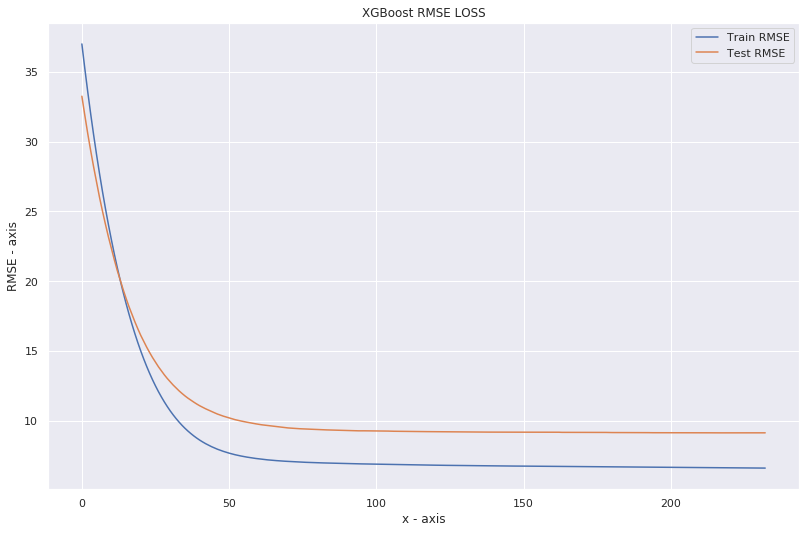

In [27]:
range_x_abs = range(len(reg_xgbooting.evals_result()['validation_0']["rmse"]))
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(range_x_abs, reg_xgbooting.evals_result()['validation_0']["rmse"], label = "Train RMSE")
plt.plot(range_x_abs, reg_xgbooting.evals_result()['validation_1']["rmse"], label = "Test RMSE")
plt.xlabel('x - axis')
plt.ylabel('RMSE - axis')
plt.title('XGBoost RMSE LOSS')
plt.legend()
plt.show()

##### Feature Importance

Means Square Error ==  5.943975590443619
Root Means Square Error ==  2.4380269872262734


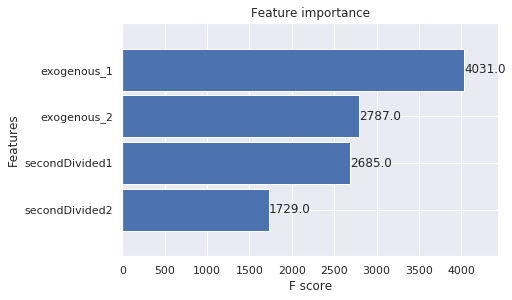

In [29]:
print("Means Square Error == ", mean_absolute_error(y_test, y_pred))
print("Root Means Square Error == ", np.sqrt(mean_absolute_error(y_test, y_pred)))
_ = plot_importance(reg_xgbooting, height=0.9)

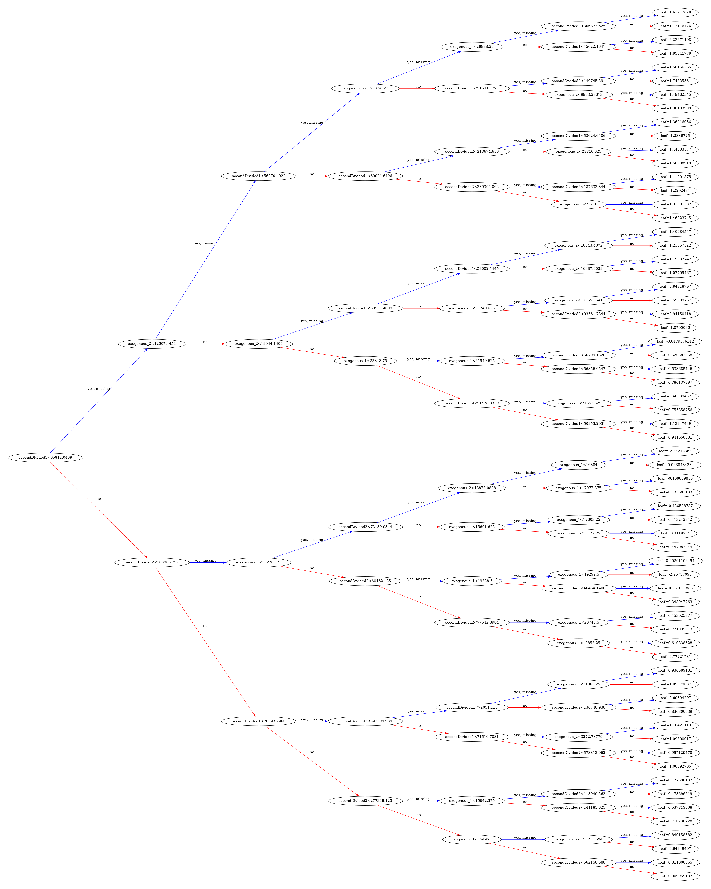

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(reg_xgbooting, num_trees=10, rankdir='LR', ax=ax);
plt.show()

##### Compare Prediction Price and Real Price

In [33]:
electricity_market_data_test['MW_Prediction'] = reg_xgbooting.predict(X_test)
electricity_market_data_all = pd.concat([electricity_market_data_test, electricity_market_data_train], sort=False)

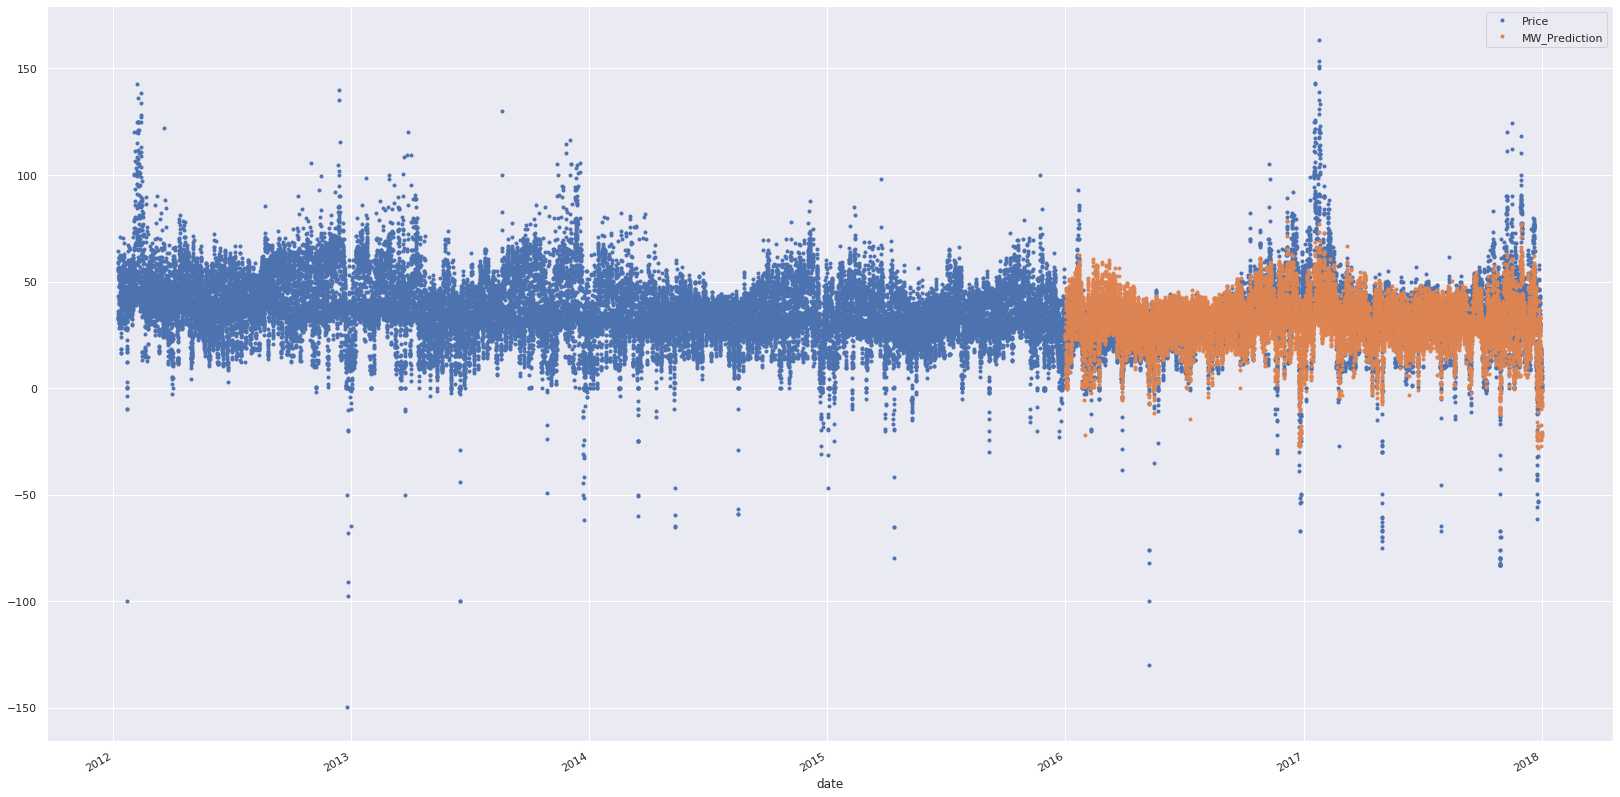

In [34]:
_ = electricity_market_data_all[['date', 'Price','MW_Prediction']].plot(x='date', style='.', figsize=(25,15))

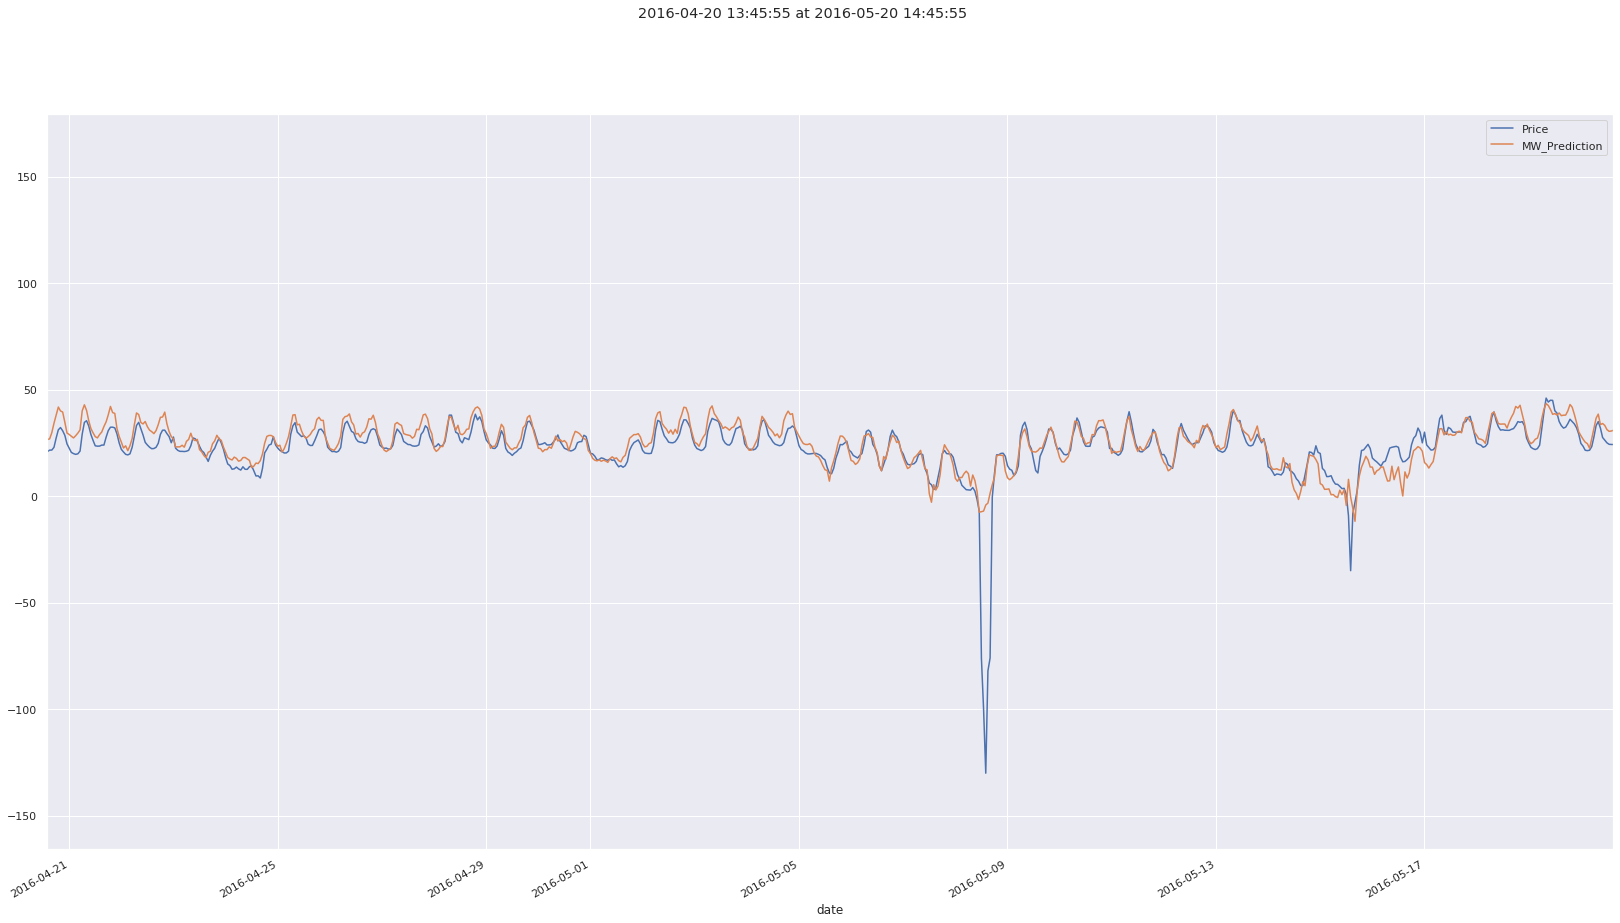

In [35]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
result_g = electricity_market_data_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-05-20 14:45:55')
plot = plt.suptitle('2016-04-20 13:45:55 at 2016-05-20 14:45:55')

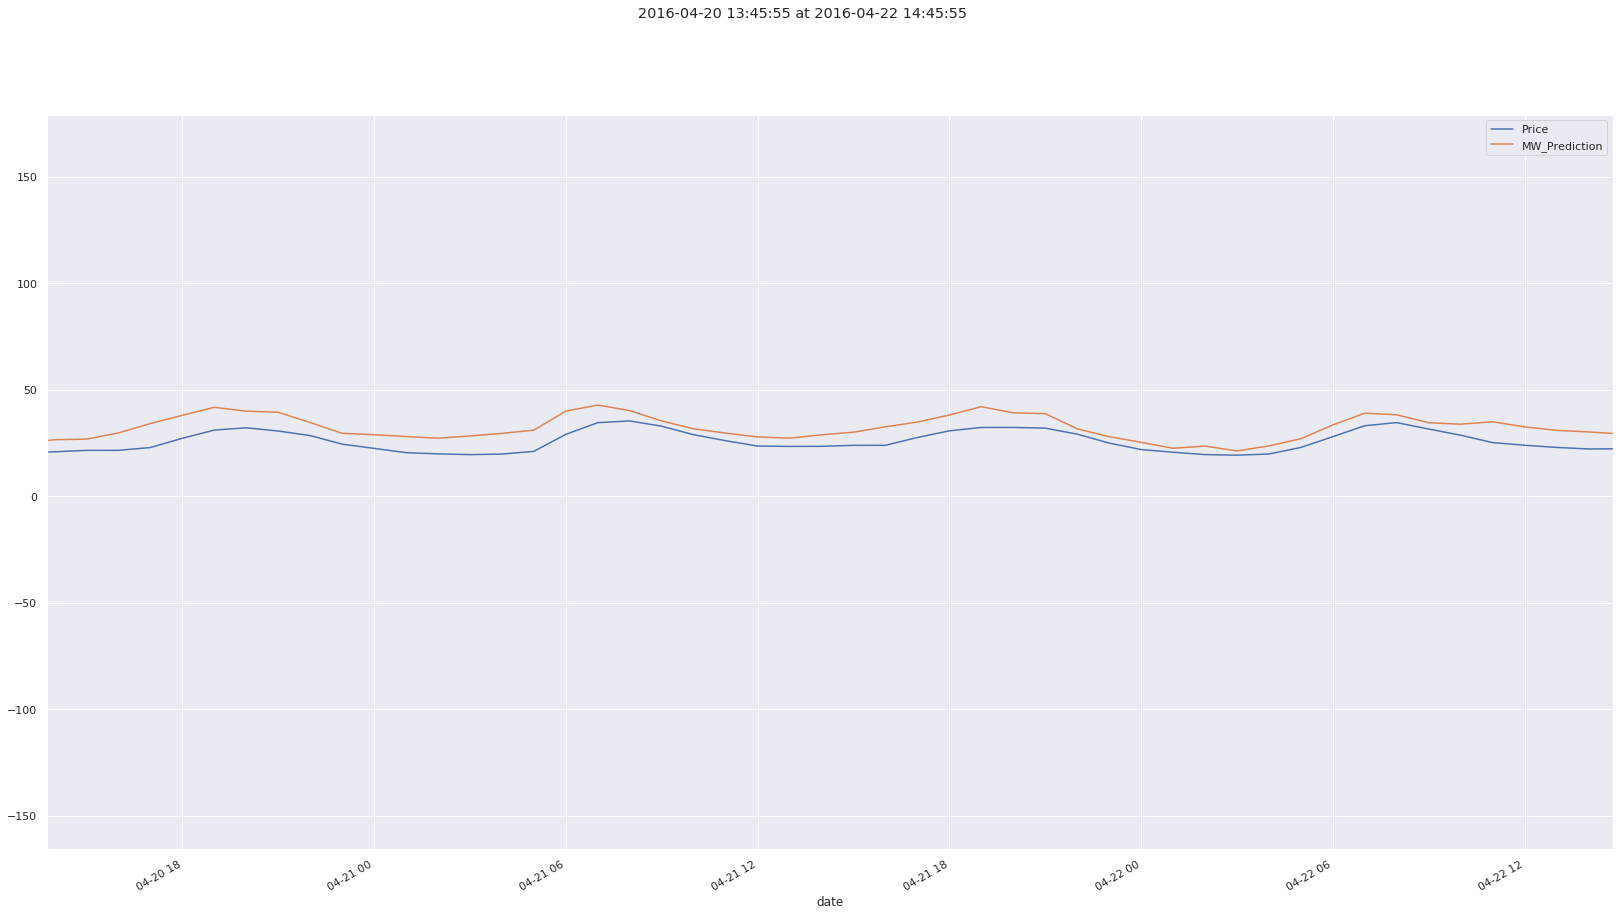

In [36]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-04-22 14:45:55')
plot = plt.suptitle('2016-04-20 13:45:55 at 2016-04-22 14:45:55')

### LIGHTGBM REGRESSOR

In [37]:
electricity_market_data = data_set#[["date", "Price"]]
split_date = '01-Jan-2016'
electricity_market_data_train = electricity_market_data.loc[electricity_market_data.date <= split_date].copy()
electricity_market_data_lgb_test = electricity_market_data.loc[electricity_market_data.date > split_date].copy()

#####  Loss Function

In [38]:
start_time = datetime.now()
model_lgb = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, n_features=20, n_informative=15, noise=0.1, objective='rmse')
model_lgb.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=10,
              verbose=False)
print(model_lgb)
predicted_y = model_lgb.predict(X_test)

thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
tmin, tsec = divmod(temp_sec, 60)
print('\nTime taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

/home/panongbene/anaconda3/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/panongbene/anaconda3/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: noise
[LightGBM] [Warning] Unknown parameter: n_features
[LightGBM] [Warning] Unknown parameter: n_informative
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_features=20, n_informative=15, n_jobs=-1,
              noise=0.1, num_leaves=31, objective='rmse', random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent='warn', subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

Time taken: 0 hours 0 minutes and 0.36 seconds.


##### Feature Importance

Means Square Error ==  5.875693140059623
Root Means Square Error ==  2.423982908367883


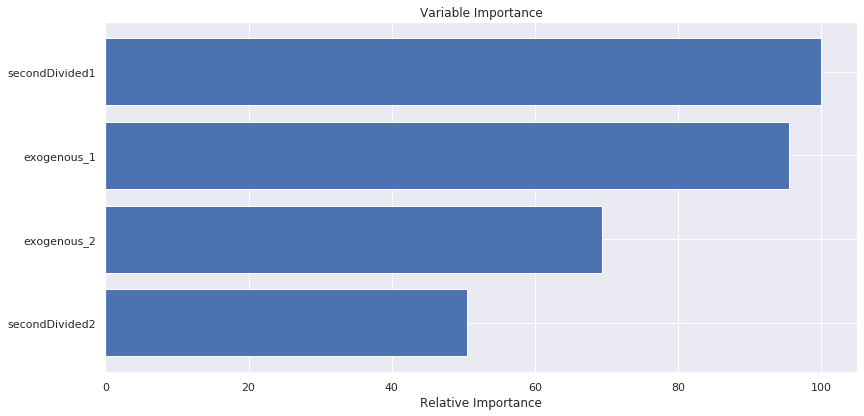

In [39]:
print("Means Square Error == ", mean_absolute_error(y_test, predicted_y))
print("Root Means Square Error == ", np.sqrt(mean_absolute_error(y_test, predicted_y)))

feature_importance = model_lgb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

##### Loss Function

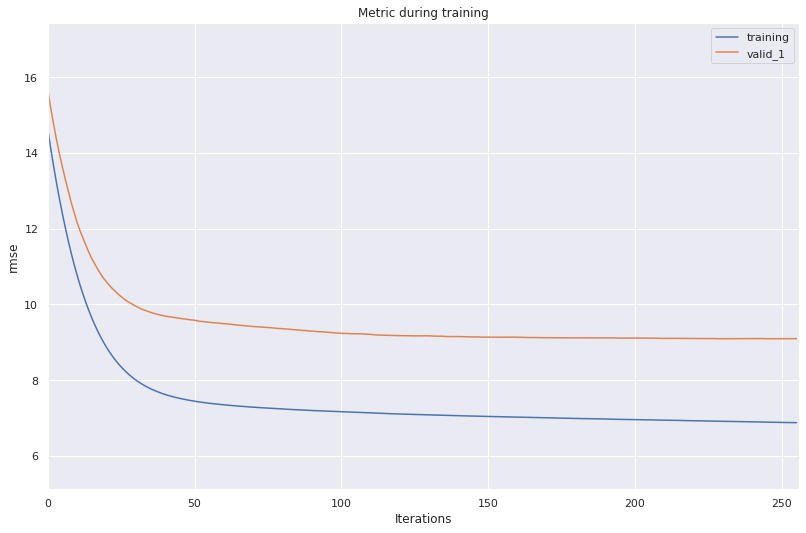

In [40]:
f, ax = plt.subplots(figsize=(12, 8))
lgb.plot_metric(model_lgb, ax=ax)

##### Compare Prediction Price and Real Price

In [41]:
electricity_market_data_lgb_test['MW_Prediction'] = model_lgb.predict(X_test)
electricity_market_data_lgb_all = pd.concat([electricity_market_data_lgb_test, electricity_market_data_train], sort=False)

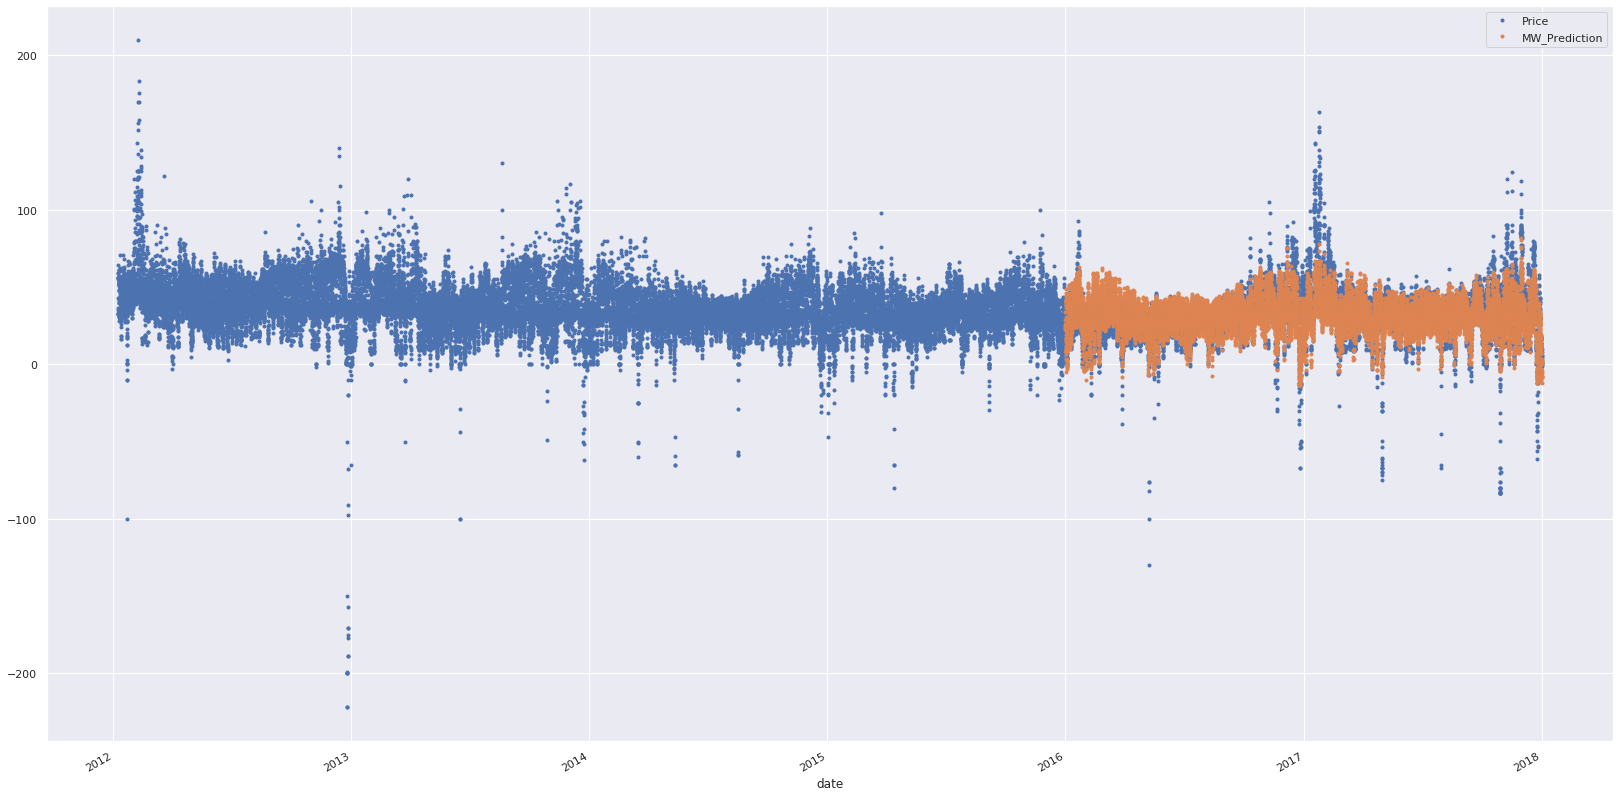

In [42]:
_ = electricity_market_data_lgb_all[['date', 'Price','MW_Prediction']].plot(x='date', style='.', figsize=(25,15))

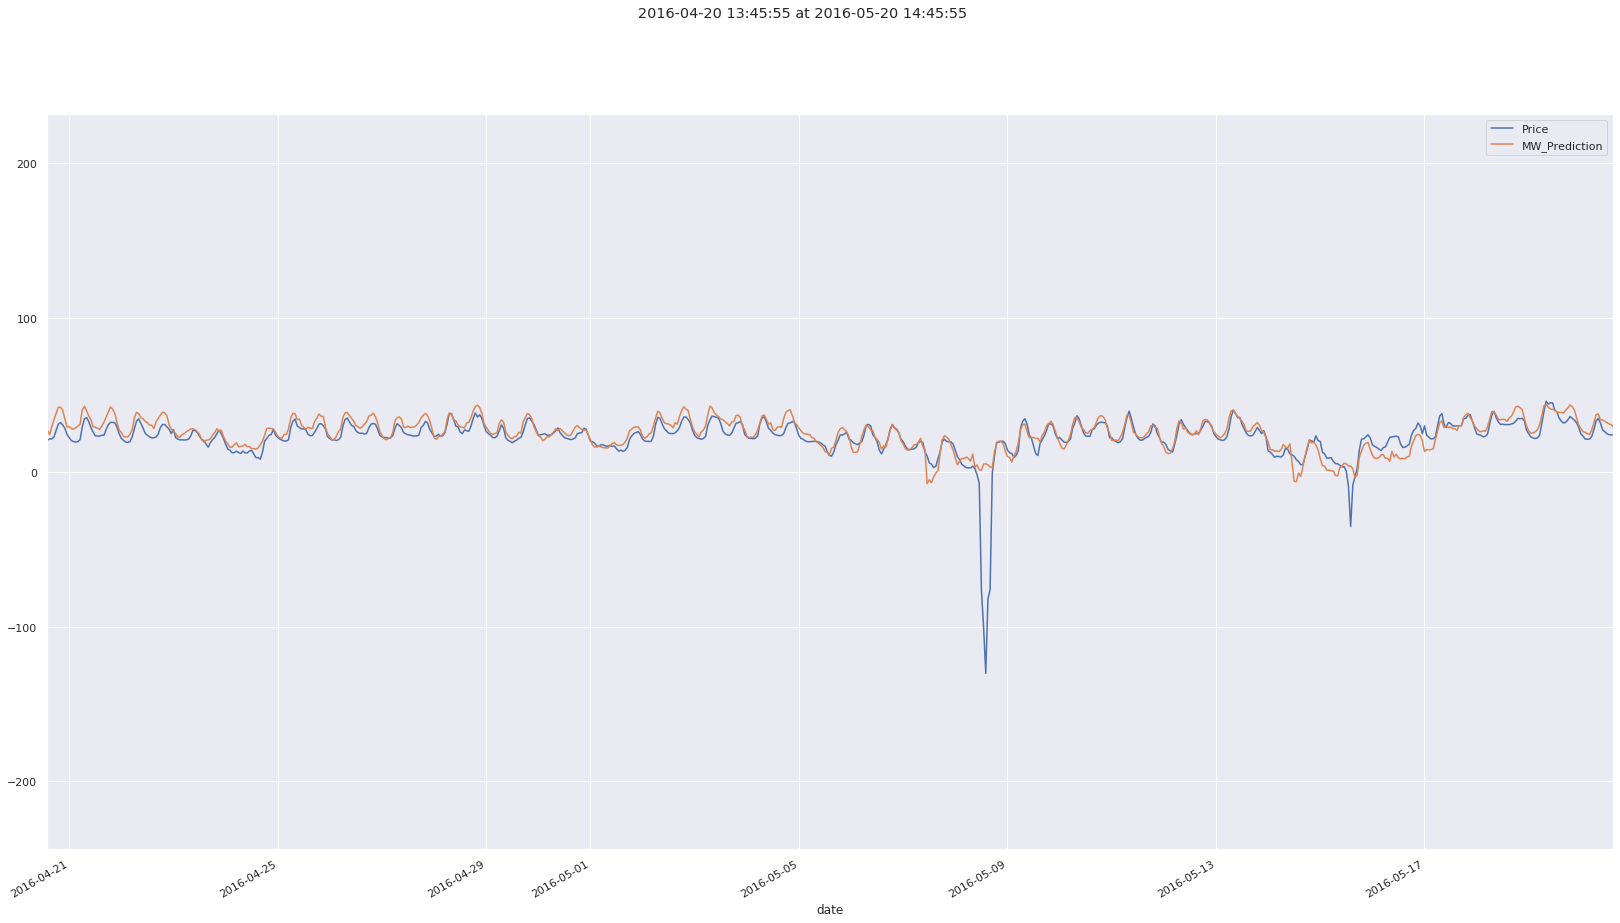

In [43]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
result_g = electricity_market_data_lgb_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-05-20 14:45:55')
#ax.set_ylim(-100, 100)
plot = plt.suptitle('2016-04-20 13:45:55 at 2016-05-20 14:45:55')

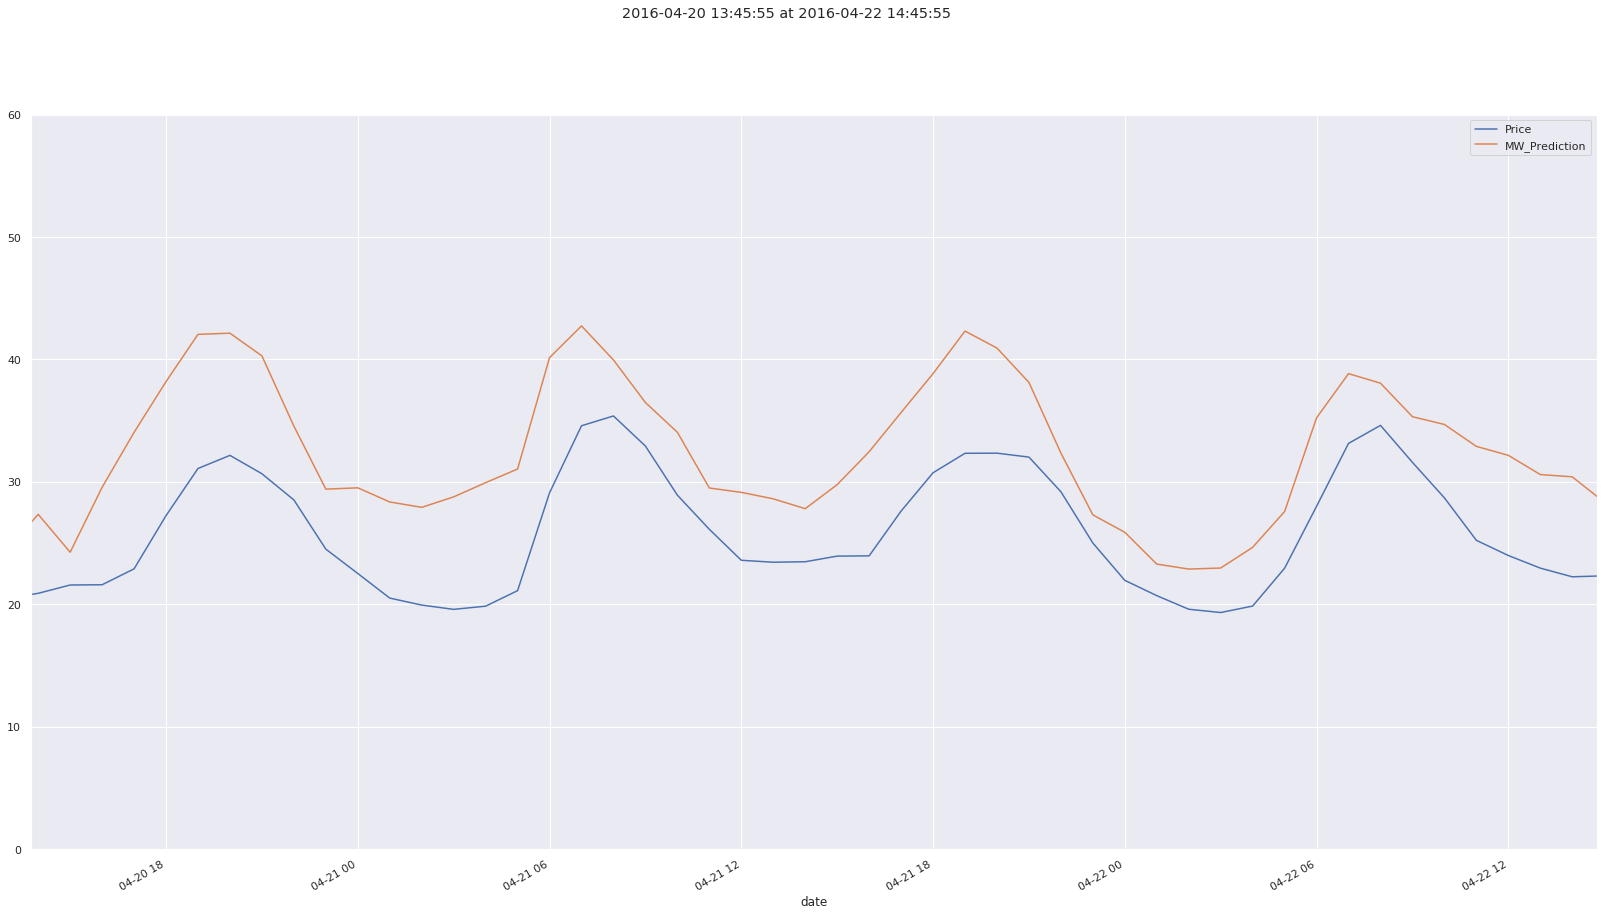

In [44]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_lgb_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-04-22 14:45:55')
ax.set_ylim(0, 60)
plot = plt.suptitle('2016-04-20 13:45:55 at 2016-04-22 14:45:55')

### Random Forest

In [45]:
electricity_market_data = data_set#[["date", "Price"]]
split_date = '01-Jan-2016'
electricity_market_data_train = electricity_market_data.loc[electricity_market_data.date <= split_date].copy()
electricity_market_data_random_forest_test = electricity_market_data.loc[electricity_market_data.date > split_date].copy()

#####  RandomizedSearchCV & Train & Loss Function

In [46]:
# Randomized Search with Cross Validation
#n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 5)]
#max_depth = [int(x) for x in np.linspace(10, 500, num = 5)]
#random_grid = {'n_estimators': n_estimators,'max_depth': max_depth}

#random_f = RandomForestRegressor()

# Cross Validation
#rf_random = RandomizedSearchCV(estimator = random_f, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
#rf_random.fit(X_train,y_train)

#print(rf_random.best_params_)

In [52]:
start_time = datetime.now()
reg_random_forest = RandomForestRegressor(n_estimators=100, criterion='mse', max_features = 'sqrt')
history = reg_random_forest.fit(X_train, y_train,
              #eval_set=[(X_train, y_train), (X_test, y_test)],
              #early_stopping_rounds=10,
            )
print(reg_random_forest)
predicted_y_random_forest = reg_random_forest.predict(X_test)

thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
tmin, tsec = divmod(temp_sec, 60)
print('\nTime taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Time taken: 0 hours 0 minutes and 7.23 seconds.


##### Feature Importance

Means Square Error ==  6.05843446958901
Root Means Square Error ==  2.4613887278504


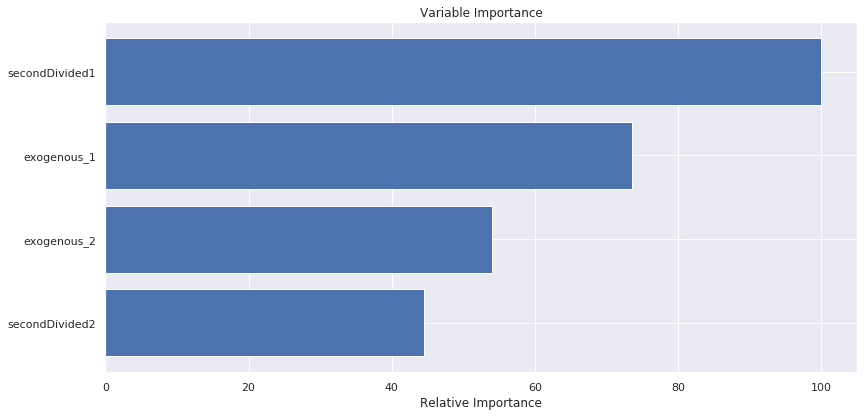

In [53]:
print("Means Square Error == ", mean_absolute_error(y_test, predicted_y_random_forest))
print("Root Means Square Error == ", np.sqrt(mean_absolute_error(y_test, predicted_y_random_forest)))

feature_importance = reg_random_forest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

##### Compare Prediction Price and Real Price

In [54]:
electricity_market_data_random_forest_test['MW_Prediction'] = reg_random_forest.predict(X_test)
electricity_market_data_random_forest_all = pd.concat([electricity_market_data_random_forest_test, electricity_market_data_train], sort=False)

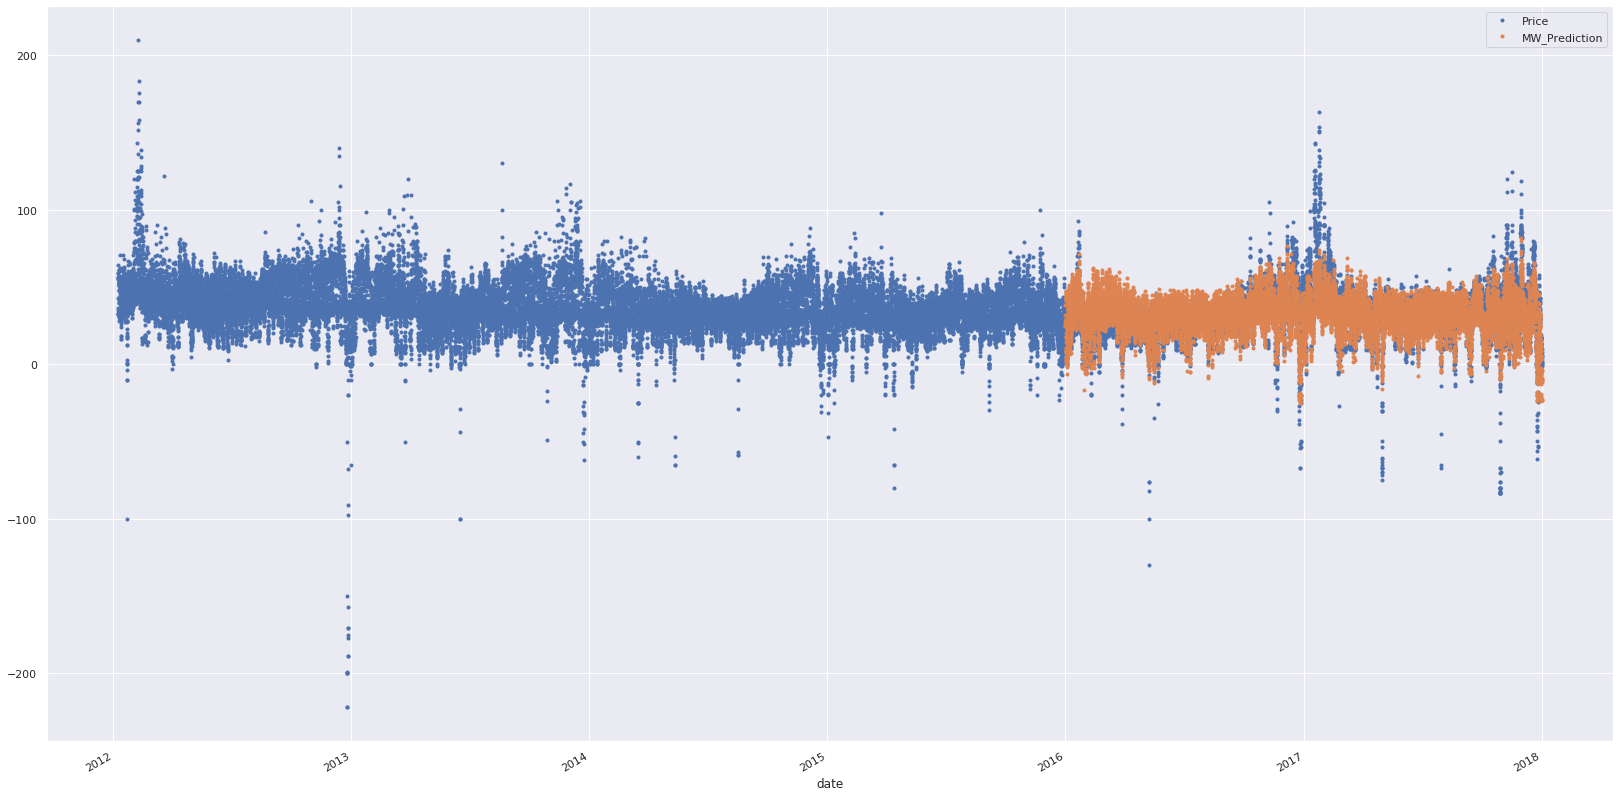

In [55]:
_ = electricity_market_data_random_forest_all[['date', 'Price','MW_Prediction']].plot(x='date', style='.', figsize=(25,15))

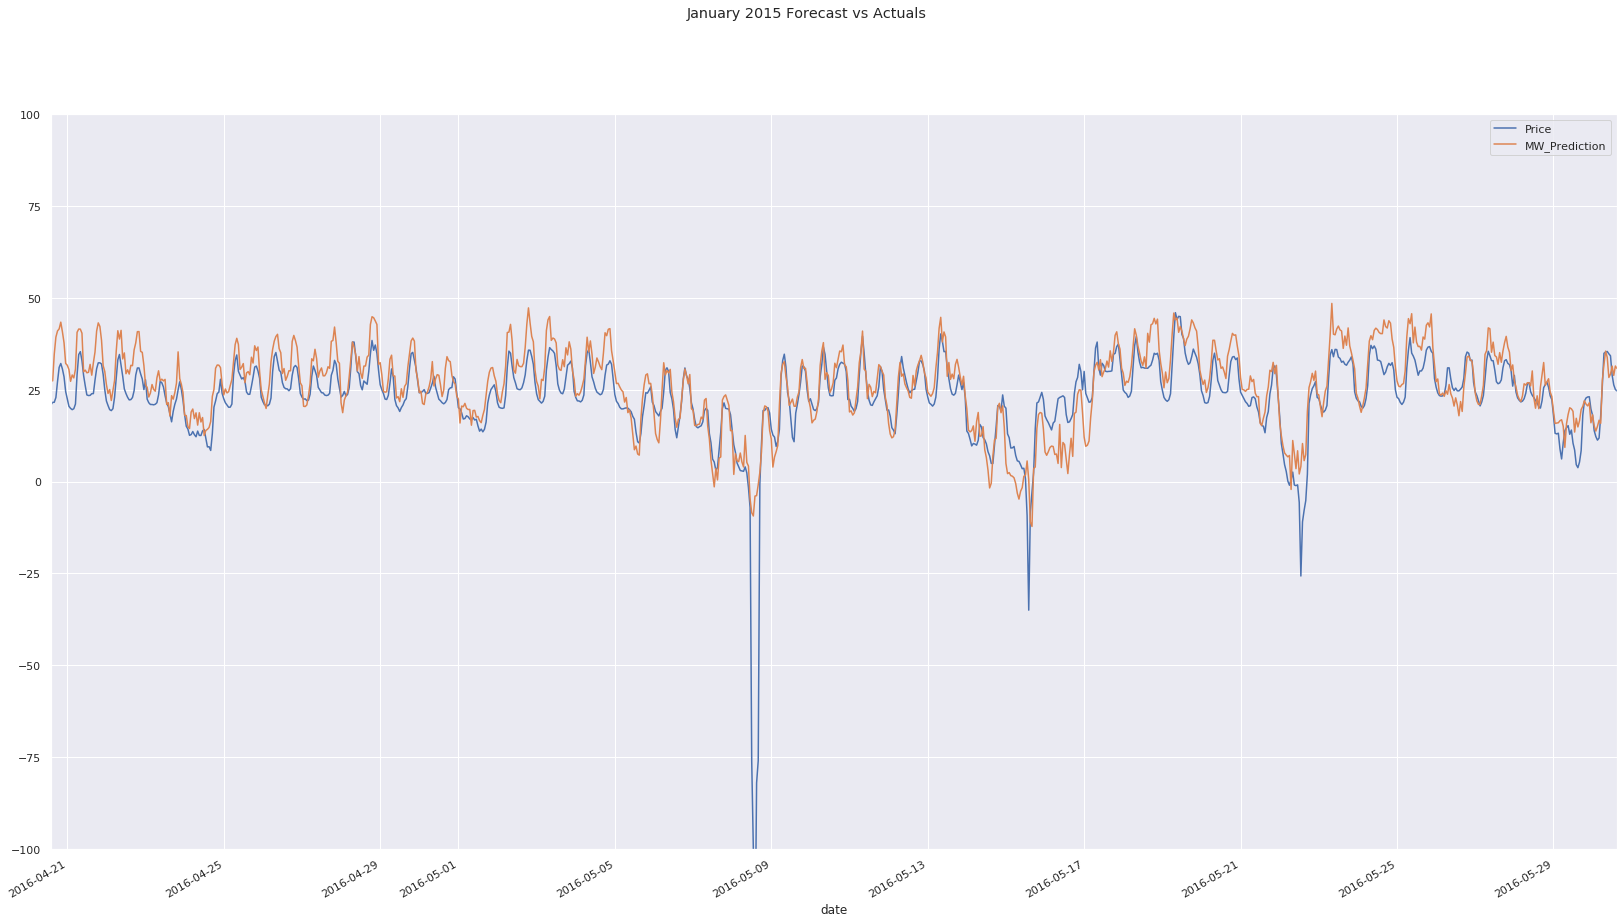

In [56]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_random_forest_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-05-30 14:45:55')
ax.set_ylim(-100, 100)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

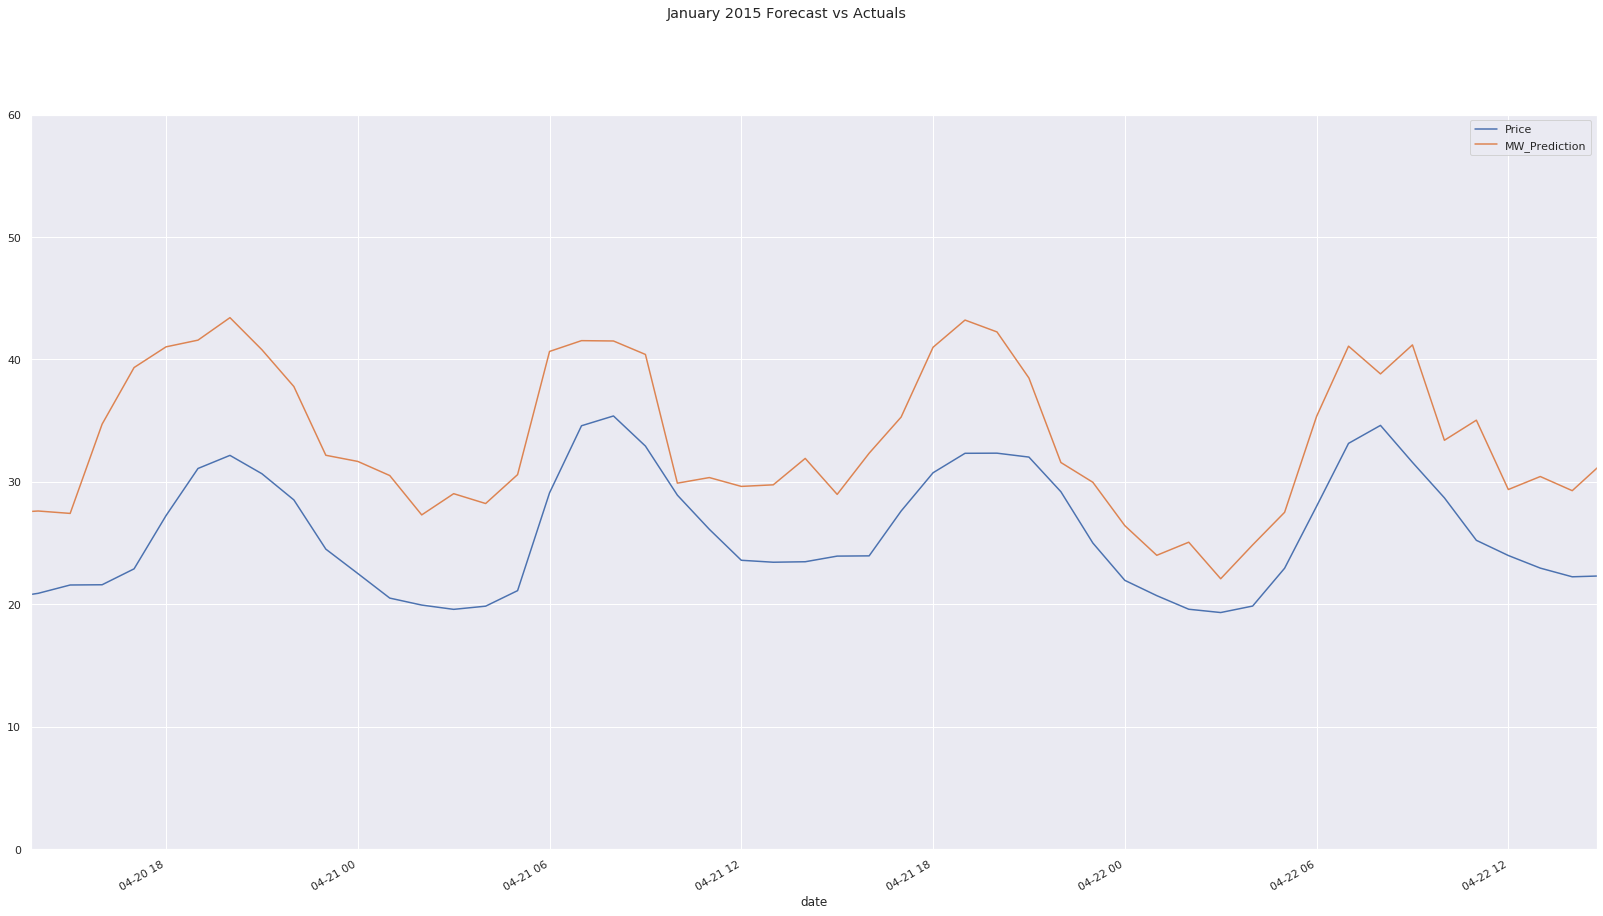

In [57]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_random_forest_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-04-22 14:45:55')
ax.set_ylim(0, 60)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### Recurrent Neural Networks

In [58]:
electricity_market_data = data_set#[["date", "Price"]]
split_date = '01-Jan-2016'
electricity_market_data_train1 = electricity_market_data.loc[electricity_market_data.date <= split_date].copy()
electricity_market_data_test1 = electricity_market_data.loc[electricity_market_data.date > split_date].copy()

In [59]:
X_train1, y_train1 = create_features(electricity_market_data_train1, label='Price')
X_test1, y_test1 = create_features(electricity_market_data_test1, label='Price')

In [60]:
lstm_model = Sequential()
lstm_model.add(LSTM(22, activation='relu', input_shape=(4,1)))
lstm_model.add(Dense(1))

In [61]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22)                2112      
                                                                 
 dense (Dense)               (None, 1)                 23        
                                                                 
Total params: 2,135
Trainable params: 2,135
Non-trainable params: 0
_________________________________________________________________


In [62]:
start_time = datetime.now()
history = lstm_model.fit(preprocessing.normalize(X_train1.values), y_train1.values, epochs=1000, batch_size=1000)

thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
tmin, tsec = divmod(temp_sec, 60)
print('\nTime taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

Epoch 1/1000
35/35 [==============================] - 1s 9ms/step - loss: 1558.4993
Epoch 2/1000
35/35 [==============================] - 0s 9ms/step - loss: 1532.2438
Epoch 3/1000
35/35 [==============================] - 0s 9ms/step - loss: 1435.2383
Epoch 4/1000
35/35 [==============================] - 0s 9ms/step - loss: 947.3286
Epoch 5/1000
35/35 [==============================] - 0s 9ms/step - loss: 340.6860
Epoch 6/1000
35/35 [==============================] - 0s 9ms/step - loss: 309.1035
Epoch 7/1000
35/35 [==============================] - 0s 9ms/step - loss: 292.1039
Epoch 8/1000
35/35 [==============================] - 0s 9ms/step - loss: 276.6572
Epoch 9/1000
35/35 [==============================] - 0s 9ms/step - loss: 263.9906
Epoch 10/1000
35/35 [==============================] - 0s 9ms/step - loss: 254.7227
Epoch 11/1000
35/35 [==============================] - 0s 9ms/step - loss: 248.5778
Epoch 12/1000
35/35 [==============================] - 0s 9ms/step - loss: 244.427

35/35 [==============================] - 0s 8ms/step - loss: 93.9433
Epoch 99/1000
35/35 [==============================] - 0s 8ms/step - loss: 93.7216
Epoch 100/1000
35/35 [==============================] - 0s 8ms/step - loss: 93.2883
Epoch 101/1000
35/35 [==============================] - 0s 8ms/step - loss: 92.8966
Epoch 102/1000
35/35 [==============================] - 0s 8ms/step - loss: 92.6344
Epoch 103/1000
35/35 [==============================] - 0s 8ms/step - loss: 92.6562
Epoch 104/1000
35/35 [==============================] - 0s 8ms/step - loss: 92.5471
Epoch 105/1000
35/35 [==============================] - 0s 8ms/step - loss: 91.9903
Epoch 106/1000
35/35 [==============================] - 0s 8ms/step - loss: 92.2849
Epoch 107/1000
35/35 [==============================] - 0s 8ms/step - loss: 91.6321
Epoch 108/1000
35/35 [==============================] - 0s 8ms/step - loss: 91.2991
Epoch 109/1000
35/35 [==============================] - 0s 8ms/step - loss: 91.2554
Epoch 11

35/35 [==============================] - 0s 8ms/step - loss: 81.3955
Epoch 196/1000
35/35 [==============================] - 0s 8ms/step - loss: 81.4139
Epoch 197/1000
35/35 [==============================] - 0s 8ms/step - loss: 81.2187
Epoch 198/1000
35/35 [==============================] - 0s 9ms/step - loss: 81.6298
Epoch 199/1000
35/35 [==============================] - 0s 8ms/step - loss: 81.0945
Epoch 200/1000
35/35 [==============================] - 0s 8ms/step - loss: 80.9697
Epoch 201/1000
35/35 [==============================] - 0s 8ms/step - loss: 80.8345
Epoch 202/1000
35/35 [==============================] - 0s 8ms/step - loss: 80.7042
Epoch 203/1000
35/35 [==============================] - 0s 8ms/step - loss: 80.6816
Epoch 204/1000
35/35 [==============================] - 0s 8ms/step - loss: 80.5149
Epoch 205/1000
35/35 [==============================] - 0s 8ms/step - loss: 80.5762
Epoch 206/1000
35/35 [==============================] - 0s 8ms/step - loss: 80.7713
Epoch 2

35/35 [==============================] - 0s 8ms/step - loss: 77.4687
Epoch 293/1000
35/35 [==============================] - 0s 9ms/step - loss: 77.3416
Epoch 294/1000
35/35 [==============================] - 0s 9ms/step - loss: 77.6100
Epoch 295/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.6630
Epoch 296/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.4529
Epoch 297/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.3156
Epoch 298/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.3640
Epoch 299/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.4943
Epoch 300/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.1499
Epoch 301/1000
35/35 [==============================] - 0s 9ms/step - loss: 77.1891
Epoch 302/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.4554
Epoch 303/1000
35/35 [==============================] - 0s 8ms/step - loss: 77.5519
Epoch 3

35/35 [==============================] - 0s 8ms/step - loss: 76.4677
Epoch 390/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.6186
Epoch 391/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.4826
Epoch 392/1000
35/35 [==============================] - 0s 9ms/step - loss: 76.4793
Epoch 393/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.3509
Epoch 394/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.4296
Epoch 395/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.5322
Epoch 396/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.6576
Epoch 397/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.6769
Epoch 398/1000
35/35 [==============================] - 0s 9ms/step - loss: 76.5248
Epoch 399/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.6844
Epoch 400/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.4809
Epoch 4

35/35 [==============================] - 0s 8ms/step - loss: 76.2996
Epoch 487/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.0609
Epoch 488/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.1041
Epoch 489/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.1236
Epoch 490/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.3291
Epoch 491/1000
35/35 [==============================] - 0s 9ms/step - loss: 76.1761
Epoch 492/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.0500
Epoch 493/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.1537
Epoch 494/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.4949
Epoch 495/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.2513
Epoch 496/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.1762
Epoch 497/1000
35/35 [==============================] - 0s 9ms/step - loss: 76.3335
Epoch 4

35/35 [==============================] - 0s 8ms/step - loss: 76.0986
Epoch 584/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.3146
Epoch 585/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.3548
Epoch 586/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.3118
Epoch 587/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.1126
Epoch 588/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.9319
Epoch 589/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.9723
Epoch 590/1000
35/35 [==============================] - 0s 9ms/step - loss: 76.0555
Epoch 591/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.9805
Epoch 592/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.9043
Epoch 593/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.2117
Epoch 594/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.2581
Epoch 5

35/35 [==============================] - 0s 8ms/step - loss: 75.7945
Epoch 681/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7806
Epoch 682/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.9891
Epoch 683/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.9231
Epoch 684/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.7933
Epoch 685/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7713
Epoch 686/1000
35/35 [==============================] - 0s 9ms/step - loss: 76.0281
Epoch 687/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.2381
Epoch 688/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.7620
Epoch 689/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8114
Epoch 690/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8944
Epoch 691/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8501
Epoch 6

35/35 [==============================] - 0s 9ms/step - loss: 75.8807
Epoch 778/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8222
Epoch 779/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7740
Epoch 780/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8041
Epoch 781/1000
35/35 [==============================] - 0s 8ms/step - loss: 76.0144
Epoch 782/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8366
Epoch 783/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7783
Epoch 784/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8128
Epoch 785/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.7306
Epoch 786/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7404
Epoch 787/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.7720
Epoch 788/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.7656
Epoch 7

35/35 [==============================] - 0s 8ms/step - loss: 75.6525
Epoch 875/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8603
Epoch 876/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7284
Epoch 877/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.7290
Epoch 878/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.5359
Epoch 879/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.6140
Epoch 880/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.7971
Epoch 881/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.9301
Epoch 882/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8315
Epoch 883/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.6290
Epoch 884/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.6394
Epoch 885/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7518
Epoch 8

35/35 [==============================] - 0s 9ms/step - loss: 75.5839
Epoch 972/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.5712
Epoch 973/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.6289
Epoch 974/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.6301
Epoch 975/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.8100
Epoch 976/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.5221
Epoch 977/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.5736
Epoch 978/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.5573
Epoch 979/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.4803
Epoch 980/1000
35/35 [==============================] - 0s 9ms/step - loss: 75.5215
Epoch 981/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.5332
Epoch 982/1000
35/35 [==============================] - 0s 8ms/step - loss: 75.7986
Epoch 9

##### Loss function

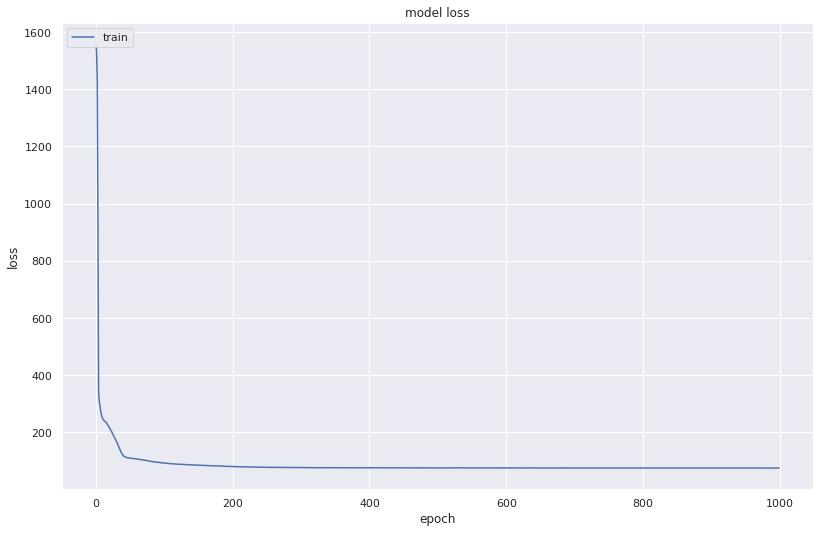

In [63]:
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
predicted_y_lstm = lstm_model.predict(preprocessing.normalize(X_test1))
predicted_y_lstm = [one_element[0] for one_element in predicted_y_lstm]

In [65]:
print("Means Square Error == ", mean_absolute_error(y_test1.values, predicted_y_lstm))
print("Root Means Square Error == ", np.sqrt(mean_absolute_error(y_test1.values, predicted_y_lstm)))

Means Square Error ==  6.874000762690568
Root Means Square Error ==  2.621831566422711


##### Compare Prediction Price and Real Price

In [66]:
predicted_y_lstm = lstm_model.predict(preprocessing.normalize(X_test1))
predicted_y_lstm = [one_element[0] for one_element in predicted_y_lstm]
electricity_market_data_test1['MW_Prediction'] = predicted_y_lstm
electricity_market_data_lsmt_all = pd.concat([electricity_market_data_test1, electricity_market_data_train1], sort=False)

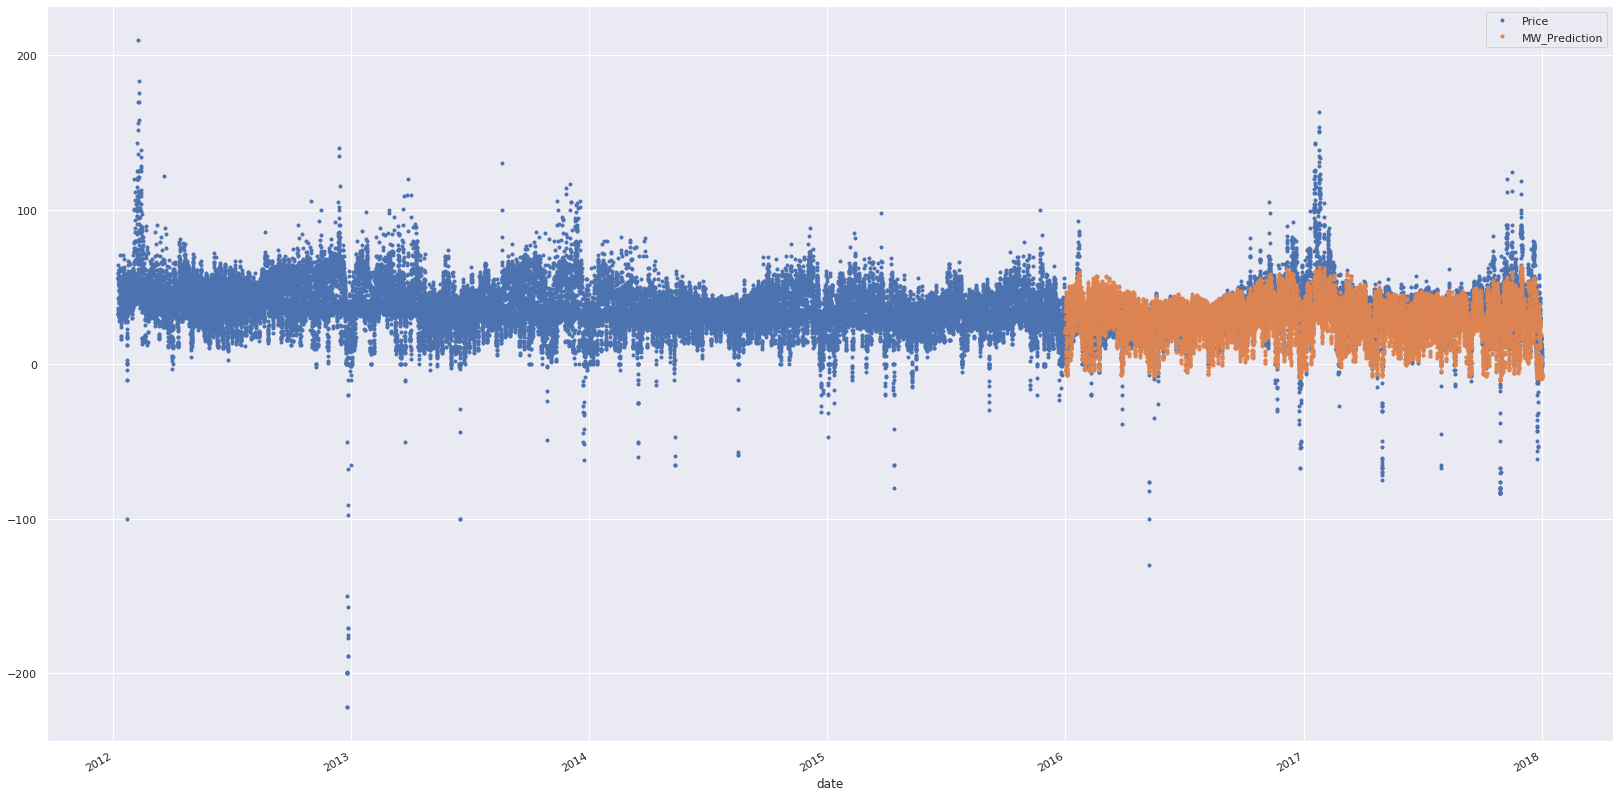

In [67]:
_ = electricity_market_data_lsmt_all[['date', 'Price','MW_Prediction']].plot(x='date', style='.', figsize=(25,15))

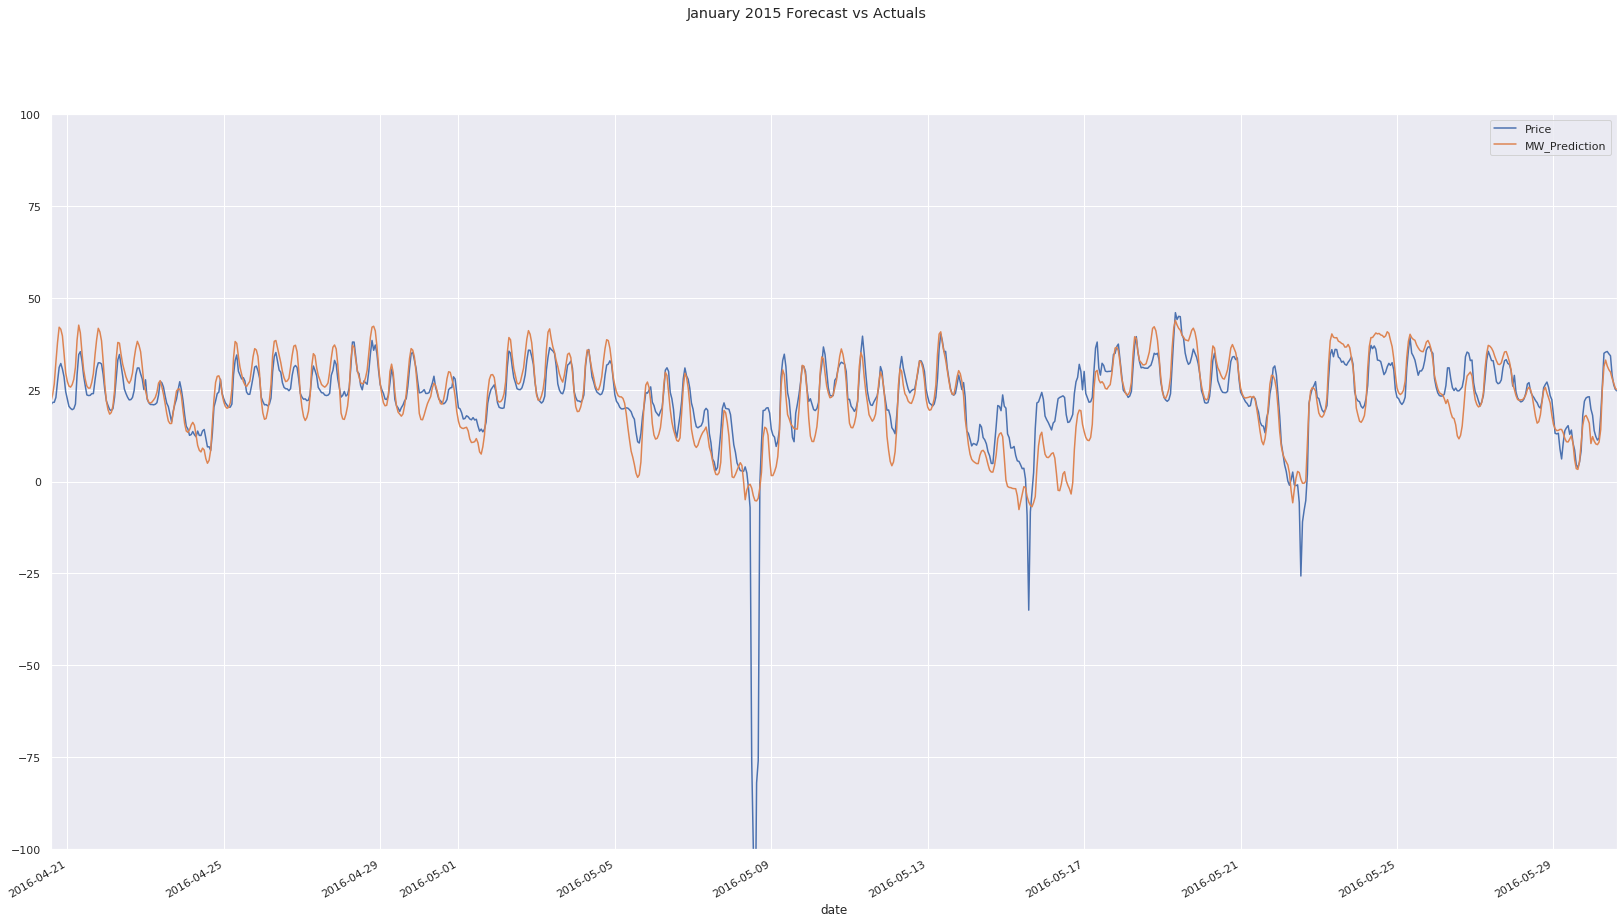

In [68]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_lsmt_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-05-30 14:45:55')
ax.set_ylim(-100, 100)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

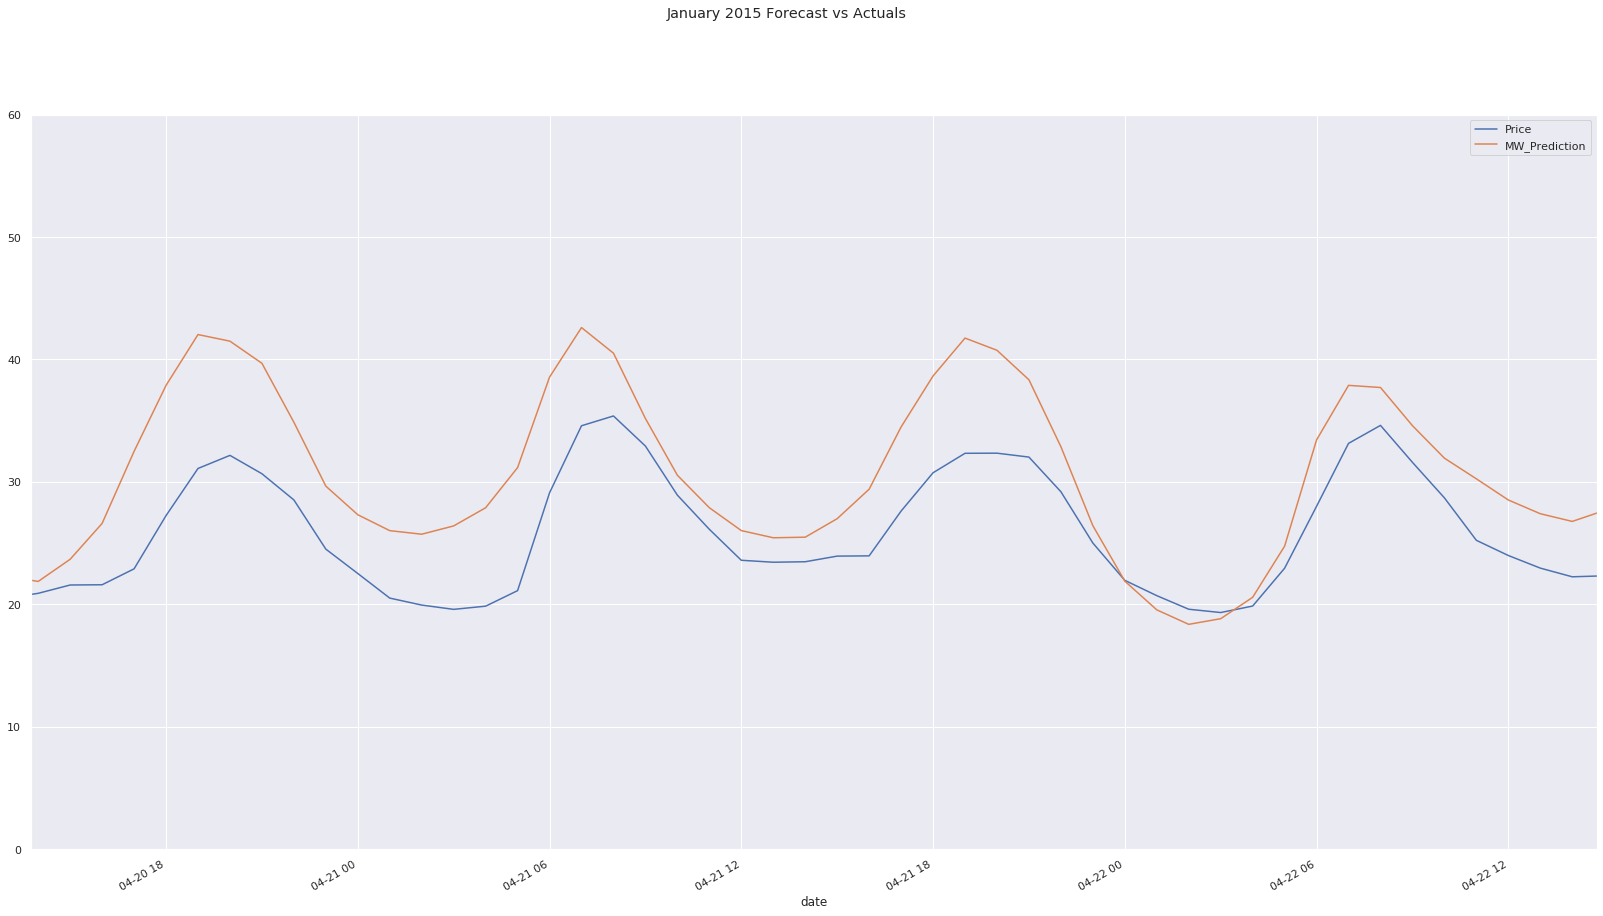

In [69]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_lsmt_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-04-22 14:45:55')
ax.set_ylim(0, 60)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

# Transformer

In [62]:
electricity_market_data = data_set#[["date", "Price"]]
split_date = '01-Jan-2016'
electricity_market_data_train2 = electricity_market_data.loc[electricity_market_data.date <= split_date].copy()
electricity_market_data_test2 = electricity_market_data.loc[electricity_market_data.date > split_date].copy()

In [63]:
X_train2, y_train2 = create_features(electricity_market_data_train2, label='Price')
X_test2, y_test2 = create_features(electricity_market_data_test2, label='Price')

In [64]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    #x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="softmax")(res)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [65]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    #for dim in mlp_units:
    #    x = layers.Dense(dim, activation="relu")(x)
    #    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)


In [66]:
input_shape = (4,1)
model = build_model(
    input_shape,
    head_size=25,
    num_heads=3,
    ff_dim=3,
    num_transformer_blocks=3,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["mean_squared_error"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 4, 1)        526         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 4, 1)        2           ['dropout[0][0]']            

In [67]:
start_time = datetime.now()
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history = model.fit(
    preprocessing.normalize(X_train2.values),
    y_train2.values,
    validation_split=0.1,
    epochs=200,
    batch_size=10,
    callbacks=callbacks,
)

thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
tmin, tsec = divmod(temp_sec, 60)
print('\nTime taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

Epoch 1/200
3139/3139 [==============================] - 23s 7ms/step - loss: 283.4920 - mean_squared_error: 283.4920 - val_loss: 191.6598 - val_mean_squared_error: 191.6598
Epoch 2/200
3139/3139 [==============================] - 20s 6ms/step - loss: 260.3835 - mean_squared_error: 260.3835 - val_loss: 168.0308 - val_mean_squared_error: 168.0308
Epoch 3/200
3139/3139 [==============================] - 20s 6ms/step - loss: 257.1925 - mean_squared_error: 257.1925 - val_loss: 156.4490 - val_mean_squared_error: 156.4490
Epoch 4/200
3139/3139 [==============================] - 21s 7ms/step - loss: 254.0770 - mean_squared_error: 254.0770 - val_loss: 172.0394 - val_mean_squared_error: 172.0394
Epoch 5/200
3139/3139 [==============================] - 21s 7ms/step - loss: 251.6244 - mean_squared_error: 251.6244 - val_loss: 165.7690 - val_mean_squared_error: 165.7690
Epoch 6/200
3139/3139 [==============================] - 19s 6ms/step - loss: 248.6723 - mean_squared_error: 248.6723 - val_loss: 

3139/3139 [==============================] - 19s 6ms/step - loss: 201.1705 - mean_squared_error: 201.1705 - val_loss: 94.0426 - val_mean_squared_error: 94.0426
Epoch 49/200
3139/3139 [==============================] - 19s 6ms/step - loss: 200.7455 - mean_squared_error: 200.7455 - val_loss: 88.7810 - val_mean_squared_error: 88.7810
Epoch 50/200
3139/3139 [==============================] - 19s 6ms/step - loss: 199.8556 - mean_squared_error: 199.8556 - val_loss: 88.5088 - val_mean_squared_error: 88.5088
Epoch 51/200
3139/3139 [==============================] - 19s 6ms/step - loss: 199.3782 - mean_squared_error: 199.3782 - val_loss: 88.1305 - val_mean_squared_error: 88.1305
Epoch 52/200
3139/3139 [==============================] - 19s 6ms/step - loss: 199.0001 - mean_squared_error: 199.0001 - val_loss: 87.8500 - val_mean_squared_error: 87.8500
Epoch 53/200
3139/3139 [==============================] - 19s 6ms/step - loss: 198.6050 - mean_squared_error: 198.6050 - val_loss: 87.9637 - val_mea

3139/3139 [==============================] - 20s 6ms/step - loss: 159.3622 - mean_squared_error: 159.3622 - val_loss: 64.0133 - val_mean_squared_error: 64.0133
Epoch 143/200
3139/3139 [==============================] - 20s 6ms/step - loss: 159.2664 - mean_squared_error: 159.2664 - val_loss: 63.3869 - val_mean_squared_error: 63.3869
Epoch 144/200
3139/3139 [==============================] - 20s 6ms/step - loss: 158.4835 - mean_squared_error: 158.4835 - val_loss: 63.8584 - val_mean_squared_error: 63.8584
Epoch 145/200
3139/3139 [==============================] - 20s 6ms/step - loss: 158.3393 - mean_squared_error: 158.3393 - val_loss: 62.3748 - val_mean_squared_error: 62.3748
Epoch 146/200
3139/3139 [==============================] - 20s 6ms/step - loss: 158.2228 - mean_squared_error: 158.2228 - val_loss: 62.4238 - val_mean_squared_error: 62.4238
Epoch 147/200
3139/3139 [==============================] - 20s 6ms/step - loss: 157.9365 - mean_squared_error: 157.9366 - val_loss: 63.6577 - va

##### Loss Function

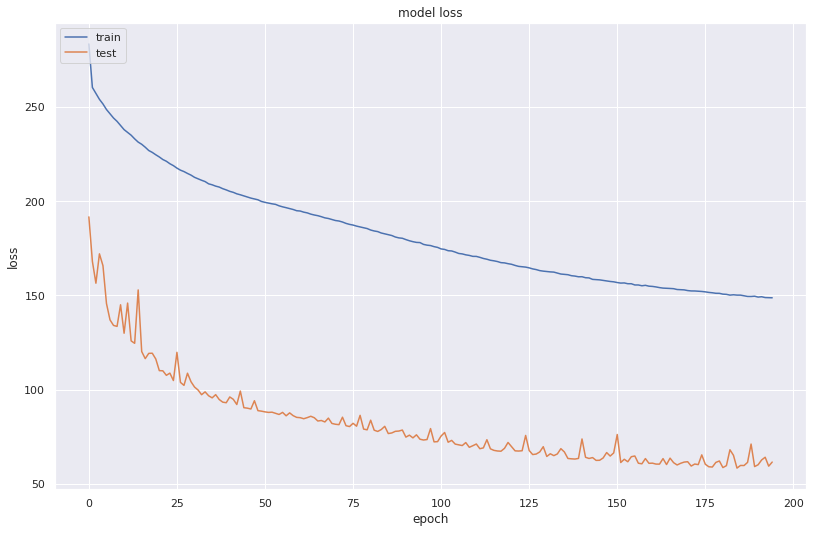

In [68]:
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
predicted_y_transformer = model.predict(preprocessing.normalize(X_test2))
predicted_y_transformer = [one_element[0] for one_element in predicted_y_transformer]

In [70]:
print("Means Square Error == ", mean_absolute_error(y_test2.values, predicted_y_transformer))
print("Root Means Square Error == ", np.sqrt(mean_absolute_error(y_test2.values, predicted_y_transformer)))

Means Square Error ==  7.815095297106653
Root Means Square Error ==  2.7955491941846873


##### Compare Prediction Price and Real Price

In [71]:
predicted_y_transformer = lstm_model.predict(preprocessing.normalize(X_test2))
predicted_y_transformer = [one_element[0] for one_element in predicted_y_transformer]
electricity_market_data_test2['MW_Prediction'] = predicted_y_transformer
electricity_market_data_transformer_all = pd.concat([electricity_market_data_test2, electricity_market_data_train2], sort=False)

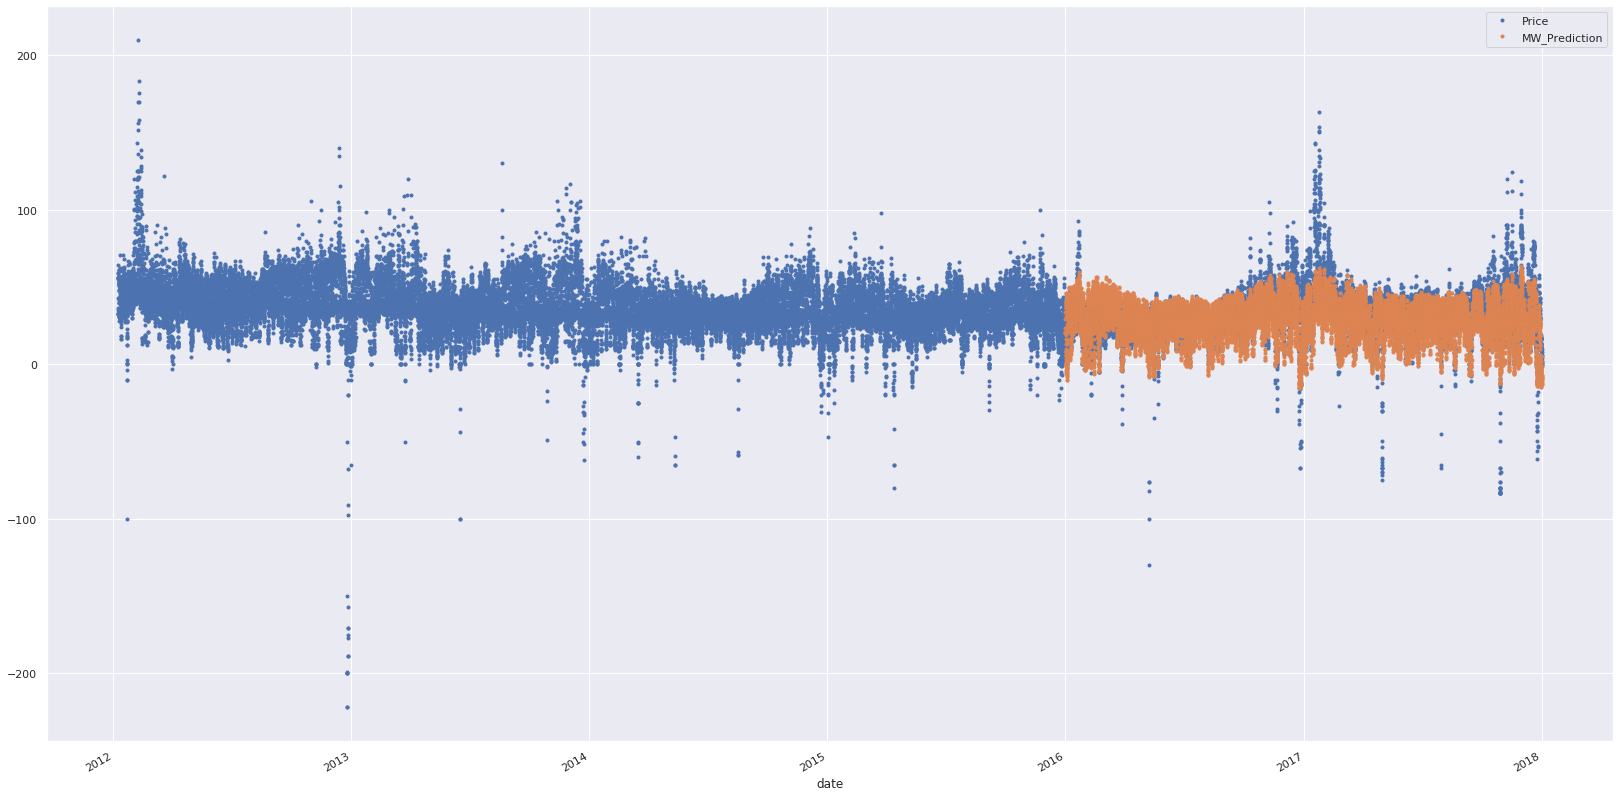

In [72]:
_ = electricity_market_data_transformer_all[['date', 'Price','MW_Prediction']].plot(x='date', style='.', figsize=(25,15))

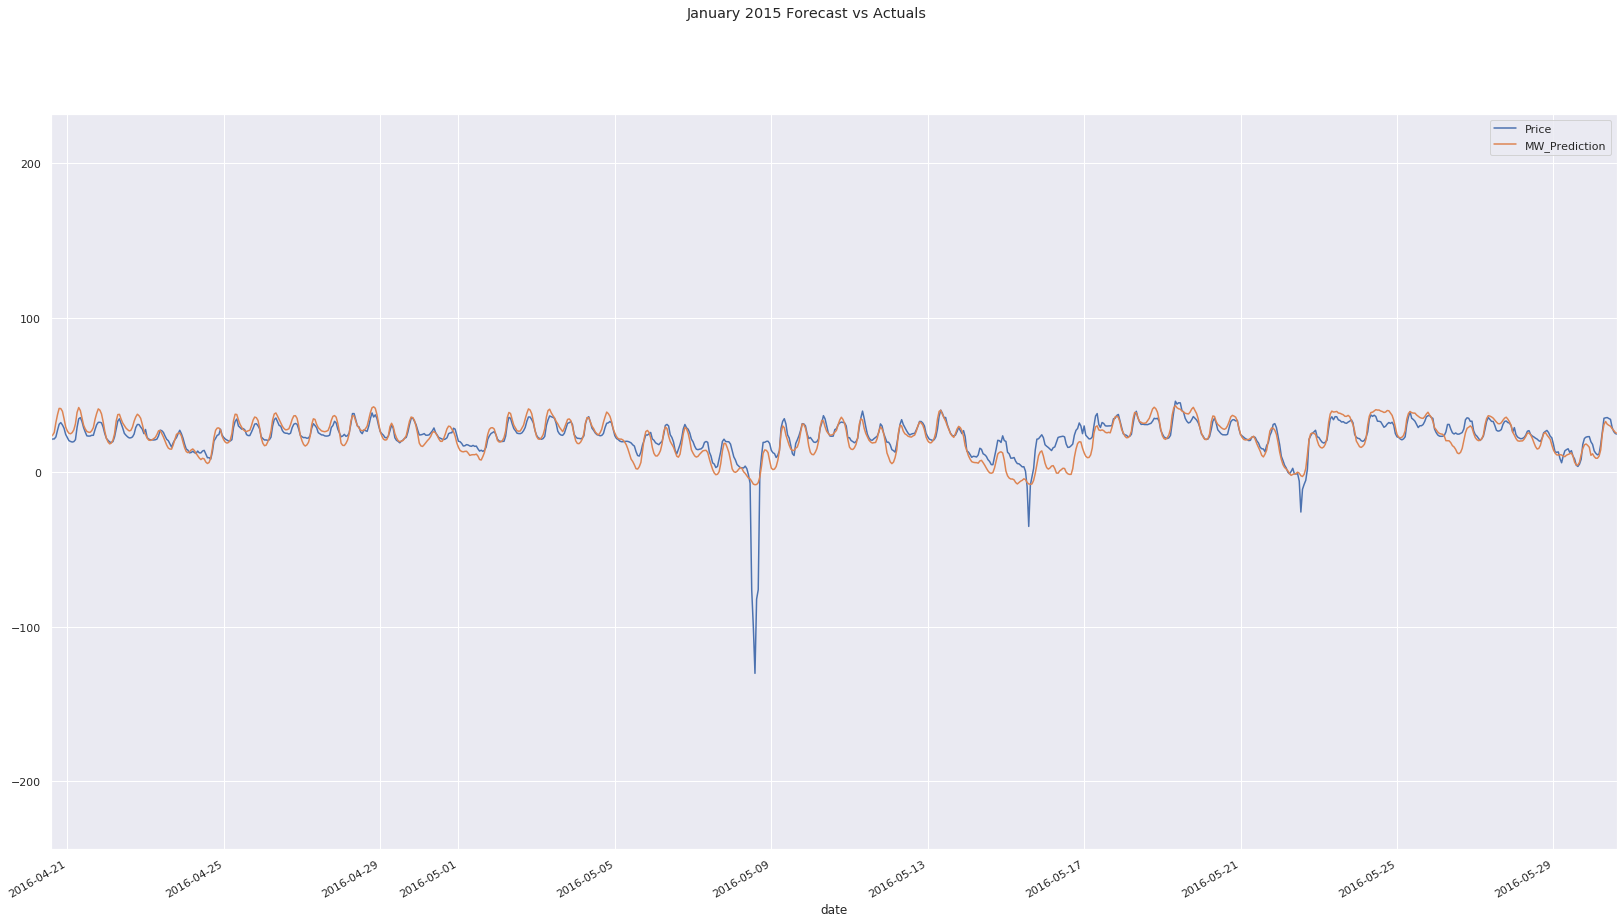

In [73]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_transformer_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-05-30 14:45:55')
plot = plt.suptitle('January 2015 Forecast vs Actuals')

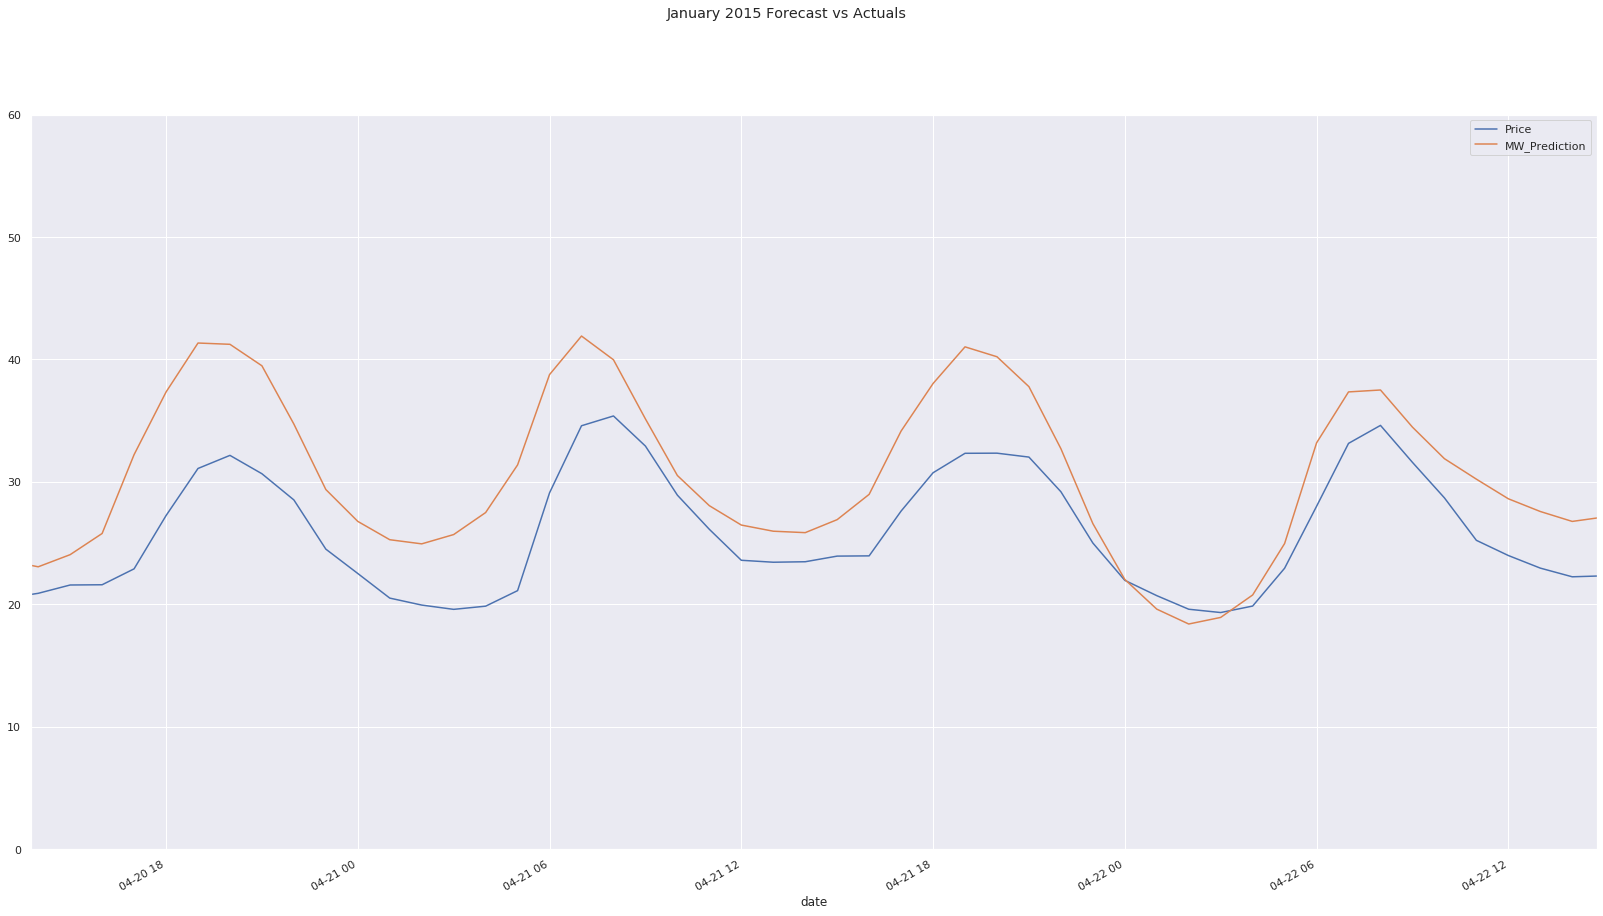

In [74]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = electricity_market_data_transformer_all[['date', 'Price', 'MW_Prediction']].plot(ax=ax, x='date',
                                              style=['-','-'], figsize=(25,15))
ax.set_xbound(lower='2016-04-20 13:45:55', upper='2016-04-22 14:45:55')
ax.set_ylim(0, 60)
plot = plt.suptitle('January 2015 Forecast vs Actuals')